In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from IPython.display import clear_output
import warnings
from sklearn.utils import shuffle
import os
import dill

from imblearn.over_sampling import SMOTE 

In [2]:
dill.load_session('Feature_selection_Classification_models_02_env.db')

# $\color{blue}{\text{Importing the dataset}}$

In [659]:
# Importing the Dataset
lisbon_coimbra_df = pd.read_excel('Lisbon_and_Coimbra_517_Proteomics.xlsx', sheet_name='517_Proteins')

# Generating the target array (y)
y = np.array([1 if i == 'Amyloid-Positive' else 0 for i in lisbon_coimbra_df['Class']]) # 1 -> Ab+      0 -> Ab-
print(f'- The number of Amyloid-Positive patients is: {list(y).count(1)} \n- The number of Amyloid-Negative patients is: {list(y).count(0)} \n')

# Dropping the useless columns 
lisbon_coimbra_df = lisbon_coimbra_df.drop(['Age', 'Gender', 'Sample code', 'Class'], axis=1)

# Generating the feature matrix (X)
X = np.array(lisbon_coimbra_df.values)
print(f'The feature matrix (X) is composed of: {X.shape[0]} examples and {X.shape[1]} features')

- The number of Amyloid-Positive patients is: 67 
- The number of Amyloid-Negative patients is: 59 

The feature matrix (X) is composed of: 126 examples and 517 features


# $\color{blue}{\text{Instantiation of the ML models}}$

In [660]:
svm_model = SVC(kernel='linear', C=10, gamma='scale')
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
lda_model = LinearDiscriminantAnalysis(solver='svd')
rdg_model = RidgeClassifier(alpha=0.01)
lr_model = LogisticRegression(C=100, penalty='l1', solver='liblinear')

models_dict = {'SVM': svm_model,
                'DT': dt_model,
                'RF': rf_model,
                'XGB': xgb_model, 
                'LDA': lda_model,
                'RDG': rdg_model,
                'LR': lr_model
                    }

# $\color{blue}{\text{Cross-Validating the models}}$

### **Defining the functions that will be used for the Cross-Validation with and without the use of SMOTE**

In [661]:
def cross_validate_balancing(estimator, X, y, balance = SMOTE(), folds=10):

    cv = StratifiedKFold(n_splits = folds, shuffle = True) 
    scores = {\
            'auc':[], \
            'accuracy': [], \
            'f1': [], \
            'precision': [], \
            'recall': []}
    
    for train_idx, test_idx in cv.split(X,y): 
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        if balance != 'None':
            X_train, y_train = balance.fit_resample(X_train, y_train)

        estimator.fit(X_train, y_train)
        y_predicted = estimator.predict(X_test)

        scores['auc'].append(roc_auc_score(y_test, y_predicted))
        scores['accuracy'].append(accuracy_score(y_test, y_predicted))
        scores['f1'].append(f1_score(y_test, y_predicted))
        scores['precision'].append(precision_score(y_test, y_predicted))
        scores['recall'].append(recall_score(y_test, y_predicted))

    return scores

In [662]:
def cv_iteration(model, X, y, iterations=10, folds=10):
    
    # Defining the final dictionary that will contain the scores
    iter_result_no_smote = {}
    iter_result_smote = {}

    for _ in range(iterations):

        if _ % 2 == 0:
            # clear_output(wait=True)
            print(f'{(_/iterations)*100}%', end=' -> ')

        result_no_smote = cross_validate_balancing(model, X, y, balance='None', folds=folds) # Calling the CV function withOUT SMOTE
        result_smote = cross_validate_balancing(model, X, y, folds=folds) # Calling the CV function with SMOTE
        result_no_smote = {k: np.mean(v) for k, v in result_no_smote.items()}
        result_smote = {k: np.mean(v) for k, v in result_smote.items()}

        # Filling the dictionary with the resuts obtained WITHOUT applying SMOTE
        for k, v in result_no_smote.items():
            if k in iter_result_no_smote.keys():
                iter_result_no_smote[k].append(v)
            else:
                iter_result_no_smote[k] = [v]

        # Filing the dictionary with the results obtained by applying the SMOTE method
        for k, v in result_smote.items():
            if k in iter_result_smote.keys():
                iter_result_smote[k].append(v)
            else:
                iter_result_smote[k] = [v]
    
    # Computing the standard deviation
    sd_dict_no_smote, sd_dict_smote = {}, {}
    # No SMOTE
    for k, v in iter_result_no_smote.items():
        sd_dict_no_smote[k] = np.std(v)  
    # With SMOTE
    for k, v in iter_result_smote.items():
        sd_dict_smote[k] = np.std(v)
                
    iter_result_no_smote = {k: np.mean(v) for k, v in iter_result_no_smote.items()}
    iter_result_smote = {k: np.mean(v) for k, v in iter_result_smote.items()}

    return iter_result_no_smote, iter_result_smote, sd_dict_no_smote, sd_dict_smote

In [663]:
def cross_validate(models_dict, X, y, iterations=10, folds=10):

    results_no_smote_df = pd.DataFrame()
    results_smote_df = pd.DataFrame()

    for key, model in models_dict.items():

        print('\n', key, '--> Executing...') 
        
        # Getting the results - Iterating n times the CV procedure
        model_result_no_smote, model_result_smote, sd_dict_no_smote, sd_dict_smote = cv_iteration(model, X, y, iterations=iterations, folds=folds)

        # Adding the SD
        # No SMOTE
        for k, v in model_result_no_smote.items():
            model_result_no_smote[k] = str(round(v, 3)) + ' +/- ' + str(round(sd_dict_no_smote[k], 2))
        # With SMOTE
        for k, v in model_result_smote.items():
            model_result_smote[k] = str(round(v, 3)) + ' +/- ' + str(round(sd_dict_smote[k], 2))

        # Preparing the result dicts to be appended to the final DF 
        new_row_no_smote = pd.Series(data=model_result_no_smote, name=key)
        new_row_smote = pd.Series(data=model_result_smote, name=key)

        # Append the results to the final DataFrame 
        results_no_smote_df = results_no_smote_df.append(new_row_no_smote, ignore_index=False)
        results_smote_df = results_smote_df.append(new_row_smote, ignore_index=False)

    print('Done')

    # Arranging the order of the columns
    cols = list(results_no_smote_df.columns)
    acc, auc = cols.index('accuracy'), cols.index('auc')
    cols[auc], cols[acc] = cols[acc], cols[auc]

    results_no_smote_df = results_no_smote_df[cols]
    results_smote_df = results_smote_df[cols]

    # Sorting the models by the results of the AUC metric
    results_no_smote_df = results_no_smote_df.sort_values(['auc'], ascending=False)
    results_smote_df = results_smote_df.sort_values(['auc'], ascending=False)

    return results_no_smote_df, results_smote_df

### **Using these function I can Cross-Validate the models**

In [664]:
warnings.filterwarnings('ignore')

# Cross-Validating the models
lisbon_coimbra_no_smote_df, lisbon_coimbra_smote_df = cross_validate(models_dict, X, y, iterations=10, folds=10)


 SVM --> Executing...
0.0% -> 20.0% -> 40.0% -> 60.0% -> 80.0% -> 
 DT --> Executing...
0.0% -> 20.0% -> 40.0% -> 60.0% -> 80.0% -> 
 RF --> Executing...
0.0% -> 20.0% -> 40.0% -> 60.0% -> 80.0% -> 
 XGB --> Executing...
0.0% -> 20.0% -> 40.0% -> 60.0% -> 80.0% -> 
 LDA --> Executing...
0.0% -> 20.0% -> 40.0% -> 60.0% -> 80.0% -> 
 RDG --> Executing...
0.0% -> 20.0% -> 40.0% -> 60.0% -> 80.0% -> 
 LR --> Executing...
0.0% -> 20.0% -> 40.0% -> 60.0% -> 80.0% -> Done


In [665]:
# Showing the results
print('The ML model results obtained withOUT the use of SMOTE are:')
lisbon_coimbra_no_smote_df

The ML model results obtained withOUT the use of SMOTE are:


,auc,accuracy,f1,precision,recall
RF,0.923 +/- 0.01,0.926 +/- 0.01,0.934 +/- 0.01,0.915 +/- 0.01,0.964 +/- 0.01
XGB,0.9 +/- 0.02,0.901 +/- 0.02,0.907 +/- 0.02,0.908 +/- 0.02,0.915 +/- 0.02
LR,0.873 +/- 0.02,0.875 +/- 0.02,0.886 +/- 0.02,0.869 +/- 0.02,0.914 +/- 0.02
LDA,0.841 +/- 0.02,0.842 +/- 0.02,0.856 +/- 0.01,0.845 +/- 0.02,0.883 +/- 0.02
DT,0.801 +/- 0.03,0.803 +/- 0.02,0.813 +/- 0.02,0.828 +/- 0.04,0.823 +/- 0.02
RDG,0.783 +/- 0.02,0.785 +/- 0.02,0.797 +/- 0.02,0.796 +/- 0.01,0.821 +/- 0.03
SVM,0.502 +/- 0.01,0.531 +/- 0.01,0.687 +/- 0.01,0.532 +/- 0.01,0.976 +/- 0.02


In [666]:
print('The ML model results obtained with the use of SMOTE are:')
lisbon_coimbra_smote_df

The ML model results obtained with the use of SMOTE are:


,auc,accuracy,f1,precision,recall
RF,0.931 +/- 0.01,0.932 +/- 0.01,0.939 +/- 0.01,0.931 +/- 0.01,0.953 +/- 0.02
XGB,0.911 +/- 0.02,0.911 +/- 0.02,0.916 +/- 0.01,0.925 +/- 0.02,0.916 +/- 0.02
LR,0.879 +/- 0.02,0.88 +/- 0.02,0.887 +/- 0.02,0.891 +/- 0.02,0.902 +/- 0.02
LDA,0.845 +/- 0.02,0.847 +/- 0.02,0.86 +/- 0.01,0.854 +/- 0.02,0.881 +/- 0.02
RDG,0.775 +/- 0.01,0.774 +/- 0.01,0.775 +/- 0.01,0.818 +/- 0.01,0.755 +/- 0.02
DT,0.772 +/- 0.02,0.774 +/- 0.02,0.785 +/- 0.03,0.8 +/- 0.02,0.795 +/- 0.05
SVM,0.581 +/- 0.02,0.572 +/- 0.02,0.509 +/- 0.04,0.665 +/- 0.04,0.446 +/- 0.04


# $\color{blue}{\text{Feature Selection}}$

#### *Defining the dictionaries that I will use to store the feature importance results of every ranking methods for each of the models*

In [667]:
feat_imp_svm, feat_imp_dt, feat_imp_rf, feat_imp_xgb, feat_imp_lda, feat_imp_rdg, feat_imp_lr = {}, {}, {}, {}, {}, {}, {}

## **1. Univariate Selection**

The key objective of this analysis is to simply describe the data to find the patterns within the data.
This is done by looking into the mean, median, mode, dispersion, variance, reange, standard deviation, etc... 

In [668]:
# Apply the SelectKBest class to order all the best features
select_best_features = SelectKBest(mutual_info_classif, k='all') 
fit_selected = select_best_features.fit(X, y)

# Defining the new dataframe with the best feature inside
df_scores = pd.DataFrame(fit_selected.scores_)
df_columns = pd.DataFrame(lisbon_coimbra_df.columns)
# Concatenation of these two dataframes
feat_imp_univ_df = pd.concat([df_columns, df_scores], axis=1)
feat_imp_univ_df.columns = ['Prot_code', 'Score']

feat_imp_univ_df[:10]

feat_imp_univ_df_sorted = feat_imp_univ_df.sort_values(['Score'], ascending=False)

feat_imp_univ_df_sorted

,Prot_code,Score
166,FETUA_HUMAN,0.213672
293,FBLN2_HUMAN,0.212962
132,IBP7_HUMAN,0.211470
130,CFAI_HUMAN,0.206867
252,CD109_HUMAN,0.200493
...,...,...
400,FRS1L_HUMAN,0.000000
401,KV106_HUMAN,0.000000
108,PRIO_HUMAN,0.000000
105,SHPS1_HUMAN,0.000000


In [669]:
# Storig the feature and their position in a dictionary
feat_imp_univ = {}

for i, feat in enumerate(list(feat_imp_univ_df_sorted['Prot_code']), 1):
    feat_imp_univ[feat] = [i]

print(list(feat_imp_univ.items())[:3])

[('FETUA_HUMAN', [1]), ('FBLN2_HUMAN', [2]), ('IBP7_HUMAN', [3])]


## **2. Single Score**  

Creates classifiers considering only one protein and rank them based on the accuracy computed in a k-fold cross validation

### ***Defining the function that I will use***

In [670]:
def cv_one_feat(Dataset, model, y, iterations=10, folds=10):

    final_results_df = pd.DataFrame()

    length = len(Dataset.keys())

    for i, feat in enumerate(Dataset.keys()):

        result_iter = {}

        print('Protein:', i)
        clear_output(wait=True)

        # Generatin the X matrix with just one feature at the time
        X_list = [[x] for x in list(Dataset[feat])]
        X_one_feat = np.array([np.array(xi) for xi in X_list])

        for _ in range(iterations):
            results = cross_validate_balancing(model, X_one_feat, y, balance='None', folds=folds) # balance='None' -> If you don't want SMOTE
            results = {k: np.mean(v) for k, v in results.items()}
            # print(results)
            
            for key, value in results.items():
                if key in result_iter.keys():
                    result_iter[key].append(value)
                else:
                    result_iter[key] = [value]

        result_iter = {k: np.mean(v) for k, v in result_iter.items()}

        # Converting the dictionary in a panda Serie so that I can that append it to the final dataframe
        new_row = pd.Series(data=result_iter, name=feat)

        # Append the new_row to the final dataframe
        final_results_df = final_results_df.append(new_row, ignore_index=False)

    # Reordering the columns of the final_results_df
    cols = list(final_results_df.columns)
    acc, auc = cols.index('accuracy'), cols.index('auc')
    cols[auc], cols[acc] = cols[acc], cols[auc]

    final_results_df = final_results_df[cols]

    # Sorting the models by the results of the AUC metric
    final_results_df = final_results_df.sort_values(['auc'], ascending=False)
      
    return final_results_df

In [671]:
def cv_one_feat_svm(Dataset, model, y, iterations=10, folds=10):

    final_results_df = pd.DataFrame()

    length = len(Dataset.keys())

    for i, feat in enumerate(Dataset.keys()):

        result_iter = []

        print('Protein:', i)
        clear_output(wait=True)

        # Generatin the X matrix with just one feature at the time
        X_list = [[x] for x in list(Dataset[feat])]
        X_one_feat = np.array([np.array(xi) for xi in X_list])

        for _ in range(iterations):
            strat_k_fold = StratifiedKFold(n_splits=folds, shuffle=True)
            results = cross_val_score(model, X_one_feat, y, cv=strat_k_fold, scoring='roc_auc') # balance='None' -> If you don't want SMOTE
            result_iter.append(np.mean(results))
        
        # Converting the dictionary in a panda Serie so that I can that append it to the final dataframe
        new_row = pd.Series(data=np.mean(result_iter), name=feat)

        # Append the new_row to the final dataframe
        final_results_df = final_results_df.append(new_row, ignore_index=False)

    # Sorting the models by the results of the AUC metric
    final_results_df.rename(columns={0: 'auc'}, inplace=True)
    final_results_df = final_results_df.sort_values(['auc'], ascending=False)
      
    return final_results_df

### **- Linear Support Vector Machine (SMV)**

In [672]:
feat_imp_ss_svm = cv_one_feat_svm(lisbon_coimbra_df, svm_model, y, iterations=10, folds=10)

Protein: 516


In [673]:
print('This are the ordered single score features that best predict the data with the model')
feat_imp_ss_svm

This are the ordered single score features that best predict the data with the model


,auc
IBP7_HUMAN,0.858778
FETUA_HUMAN,0.855032
NBL1_HUMAN,0.779849
TTHY_HUMAN,0.764079
FINC_HUMAN,0.744325
...,...
CO8B_HUMAN,0.377302
THBG_HUMAN,0.377214
FIBB_HUMAN,0.376778
C4BPA_HUMAN,0.373683


#### Storing the ordered features in a dictionary

In [674]:
# Storing the SVM results
for i, feat in enumerate(list(feat_imp_ss_svm.index), 1):
    # print(i, feat)
    if feat in feat_imp_svm.keys():
        feat_imp_svm[feat].append(i)
    else:
        feat_imp_svm[feat] = [i]

print(list(feat_imp_svm.items())[:3])

[('IBP7_HUMAN', [1]), ('FETUA_HUMAN', [2]), ('NBL1_HUMAN', [3])]


### **- Decision Tree (DT)**

In [675]:
feat_imp_ss_dt = cv_one_feat(lisbon_coimbra_df, dt_model, y, iterations=10, folds=10)

Protein: 516


In [676]:
print('This are the ordered single score features that best predict the data with DT')
feat_imp_ss_dt

This are the ordered single score features that best predict the data with DT


,auc,accuracy,f1,precision,recall
FETUA_HUMAN,0.752071,0.753718,0.767046,0.773409,0.787143
CFAI_HUMAN,0.742857,0.742692,0.751851,0.769385,0.752381
FBLN2_HUMAN,0.725810,0.727308,0.743911,0.758259,0.755952
LV746_HUMAN,0.692190,0.697179,0.721900,0.717352,0.754048
NRX2A_HUMAN,0.688214,0.691090,0.703811,0.713911,0.714762
...,...,...,...,...,...
KV106_HUMAN,0.392214,0.392179,0.388817,0.410679,0.381429
SPRL1_HUMAN,0.391786,0.393910,0.408160,0.421333,0.410238
PTPRG_HUMAN,0.380262,0.383590,0.423024,0.417218,0.441190
CO2_HUMAN,0.378595,0.379744,0.379209,0.392437,0.391190


#### Storing the ordered features in a dictionary

In [677]:
# Storing the DT results
for i, feat in enumerate(list(feat_imp_ss_dt.index), 1):
    # print(i, feat)
    if feat in feat_imp_dt.keys():
        feat_imp_dt[feat].append(i)
    else:
        feat_imp_dt[feat] = [i]

print(list(feat_imp_dt.items())[:3])

[('FETUA_HUMAN', [1]), ('CFAI_HUMAN', [2]), ('FBLN2_HUMAN', [3])]


### **- Random Forest (RF)**

In [678]:
feat_imp_ss_rf = cv_one_feat(lisbon_coimbra_df, rf_model, y, iterations=10, folds=10)

Protein: 516


In [679]:
print('This are the ordered single score features that best predict the data with RF')
feat_imp_ss_rf

This are the ordered single score features that best predict the data with RF


,auc,accuracy,f1,precision,recall
CFAI_HUMAN,0.746595,0.748526,0.760320,0.773040,0.766190
FETUA_HUMAN,0.740381,0.742949,0.756408,0.773511,0.763095
FBLN2_HUMAN,0.722667,0.724744,0.739591,0.747800,0.753333
CAH1_HUMAN,0.696190,0.694808,0.696972,0.741931,0.685714
LV746_HUMAN,0.686857,0.690705,0.711485,0.709450,0.734048
...,...,...,...,...,...
KV106_HUMAN,0.392286,0.393141,0.412834,0.422468,0.416905
PRIO_HUMAN,0.391405,0.388141,0.374359,0.404206,0.367143
PTPRG_HUMAN,0.372690,0.376923,0.420205,0.411228,0.444048
CO2_HUMAN,0.360262,0.362372,0.382965,0.385522,0.391190


#### Storing the ordered features in a dictionary

In [680]:
# Storing the RF results
for i, feat in enumerate(list(feat_imp_ss_rf.index), 1):
    # print(i, feat)
    if feat in feat_imp_rf.keys():
        feat_imp_rf[feat].append(i)
    else:
        feat_imp_rf[feat] = [i]

print(list(feat_imp_rf.items())[:3])

[('CFAI_HUMAN', [1]), ('FETUA_HUMAN', [2]), ('FBLN2_HUMAN', [3])]


### **- XGBoost (XGB)**

In [681]:
feat_imp_ss_xgb = cv_one_feat(lisbon_coimbra_df, xgb_model, y, iterations=10, folds=10)

Protein: 516


In [682]:
print('This are the ordered single score features that best predict the data with SVM')
feat_imp_ss_xgb

This are the ordered single score features that best predict the data with SVM


,auc,accuracy,f1,precision,recall
CFAI_HUMAN,0.745262,0.746538,0.756154,0.771165,0.767857
FETUA_HUMAN,0.739857,0.741090,0.752298,0.767571,0.757381
FBLN2_HUMAN,0.738119,0.739167,0.752143,0.763671,0.763571
CAH1_HUMAN,0.706000,0.704679,0.709169,0.740122,0.700000
LV746_HUMAN,0.699000,0.701538,0.719251,0.724572,0.738333
...,...,...,...,...,...
APLP2_HUMAN,0.396524,0.395769,0.399913,0.421550,0.397381
CSTN3_HUMAN,0.391071,0.389487,0.385188,0.409377,0.377143
CO2_HUMAN,0.383833,0.386218,0.410346,0.413313,0.420000
1433Z_HUMAN,0.377714,0.382756,0.419120,0.407772,0.443095


#### Storing the ordered features in a dictionary

In [683]:
# Storing the SVM results
for i, feat in enumerate(list(feat_imp_ss_xgb.index), 1):
    # print(i, feat)
    if feat in feat_imp_xgb.keys():
        feat_imp_xgb[feat].append(i)
    else:
        feat_imp_xgb[feat] = [i]

print(list(feat_imp_xgb.items())[:3])

[('CFAI_HUMAN', [1]), ('FETUA_HUMAN', [2]), ('FBLN2_HUMAN', [3])]


### **- Linear Discriminant Analysis (LDA)**

In [684]:
feat_imp_ss_lda = cv_one_feat(lisbon_coimbra_df, lda_model, y, iterations=10, folds=10)

Protein: 516


In [685]:
print('This are the ordered single score features that best predict the data with SVM')
feat_imp_ss_lda

This are the ordered single score features that best predict the data with SVM


,auc,accuracy,f1,precision,recall
FETUA_HUMAN,0.812071,0.817115,0.838337,0.800611,0.893810
IBP7_HUMAN,0.802905,0.804487,0.817566,0.812071,0.837143
NBL1_HUMAN,0.737167,0.739359,0.753768,0.760496,0.768333
SODE_HUMAN,0.713833,0.721923,0.759692,0.709421,0.835000
AACT_HUMAN,0.705952,0.706282,0.721721,0.733167,0.731905
...,...,...,...,...,...
ADIPO_HUMAN,0.451762,0.471731,0.602482,0.492428,0.802857
CD44_HUMAN,0.451762,0.478590,0.639604,0.502278,0.887857
PGCB_HUMAN,0.447405,0.464679,0.584871,0.492519,0.738810
CAD15_HUMAN,0.446119,0.464423,0.588278,0.484903,0.783571


#### Storing the ordered features in a dictionary

In [686]:
# Storing the SVM results
for i, feat in enumerate(list(feat_imp_ss_lda.index), 1):
    # print(i, feat)
    if feat in feat_imp_lda.keys():
        feat_imp_lda[feat].append(i)
    else:
        feat_imp_lda[feat] = [i]

print(list(feat_imp_lda.items())[:3])

[('FETUA_HUMAN', [1]), ('IBP7_HUMAN', [2]), ('NBL1_HUMAN', [3])]


### **- Ridge (RDG)**

In [687]:
feat_imp_ss_rdg = cv_one_feat(lisbon_coimbra_df, rdg_model, y, iterations=10, folds=10)

Protein: 516


In [688]:
print('This are the ordered single score features that best predict the data with SVM')
feat_imp_ss_rdg

This are the ordered single score features that best predict the data with SVM


,auc,accuracy,f1,precision,recall
TTHY_HUMAN,0.678524,0.690000,0.749287,0.663623,0.877381
CO3_HUMAN,0.584381,0.604744,0.717010,0.584074,0.939762
ALBU_HUMAN,0.581262,0.592308,0.657980,0.589484,0.762857
TRFE_HUMAN,0.549190,0.553397,0.588326,0.575368,0.622381
HPT_HUMAN,0.517643,0.547179,0.699645,0.541008,0.992619
...,...,...,...,...,...
IGHG2_HUMAN,0.499810,0.529808,0.689292,0.531280,0.984286
APOE_HUMAN,0.493452,0.524167,0.687093,0.527650,0.986905
IGG1_HUMAN,0.490214,0.518590,0.674382,0.525444,0.946429
CLUS_HUMAN,0.489048,0.519487,0.680893,0.524578,0.973095


#### Storing the ordered features in a dictionary

In [689]:
# Storing the SVM results
for i, feat in enumerate(list(feat_imp_ss_rdg.index), 1):
    # print(i, feat)
    if feat in feat_imp_rdg.keys():
        feat_imp_rdg[feat].append(i)
    else:
        feat_imp_rdg[feat] = [i]

print(list(feat_imp_rdg.items())[:3])

[('TTHY_HUMAN', [1]), ('CO3_HUMAN', [2]), ('ALBU_HUMAN', [3])]


### **- Logistic Regression (LR)**

In [690]:
feat_imp_ss_lr = cv_one_feat(lisbon_coimbra_df, lr_model, y, iterations=10, folds=10)

Protein: 516


In [691]:
print('This are the ordered single score features that best predict the data with SVM')
feat_imp_ss_lr

This are the ordered single score features that best predict the data with SVM


,auc,accuracy,f1,precision,recall
FETUA_HUMAN,0.740881,0.753013,0.807156,0.705359,0.956429
AACT_HUMAN,0.703476,0.706795,0.723291,0.718558,0.749286
CO3_HUMAN,0.688786,0.691538,0.716275,0.710276,0.745238
TTHY_HUMAN,0.687857,0.693013,0.731827,0.693748,0.797381
FINC_HUMAN,0.687810,0.691474,0.716474,0.705028,0.744286
...,...,...,...,...,...
IGG1_HUMAN,0.486095,0.508654,0.641799,0.518442,0.857857
PTGDS_HUMAN,0.481833,0.510513,0.664887,0.517166,0.938333
FBLN3_HUMAN,0.480643,0.505513,0.640766,0.514455,0.870952
A1AT_HUMAN,0.475690,0.500897,0.647775,0.514852,0.884048


#### Storing the ordered features in a dictionary

In [692]:
# Storing the SVM results
for i, feat in enumerate(list(feat_imp_ss_lr.index), 1):
    # print(i, feat)
    if feat in feat_imp_lr.keys():
        feat_imp_lr[feat].append(i)
    else:
        feat_imp_lr[feat] = [i]

print(list(feat_imp_lr.items())[:3])

[('FETUA_HUMAN', [1]), ('AACT_HUMAN', [2]), ('CO3_HUMAN', [3])]


## **3. Attributes' weights**

Train classifiers and rank the features based on default feature weighting method. The importance of each feature is obtained either through a *coef_attribute* or throuugh *feature_importance_attribute*.

#### *Defining the function that I will use*

In [693]:
def feat_importance(model, Dataset, X, y, iterations=100):
    score_feature_dict = {}

    for i in range(iterations):

        if i % 10 == 0:
            clear_output(wait=True)
            print(f'{(i/iterations)*100}%')

        # Fitting the model
        model.fit(X, y)

        # Extracting the important features
        feature_importance = model.feature_importances_

        for i, score in enumerate(feature_importance):
            if Dataset.keys()[i] in score_feature_dict.keys():
                score_feature_dict[Dataset.keys()[i]].append(score)
            else:
                score_feature_dict[Dataset.keys()[i]] = [score]

    # Computing the mean of the sores from the different iterations for each of the features
    score_feature_dict = {k: np.mean(v) for k, v in score_feature_dict.items()}

    features_sorted = dict(sorted(score_feature_dict.items(), key=lambda x: x[1], reverse=True))

    feature_importance_name = list(features_sorted.keys())

    return(features_sorted, feature_importance_name)

In [694]:
def coef_feat(model, Dataset, X, y, iterations=100):

    score_feature_dict = {}

    for i in range(iterations):

        if i % 10 == 0:
            clear_output(wait=True)
            print(f'{(i/iterations)*100}%')

        # Fitting the model
        model.fit(X, y)

        # Extracting the important features
        feature_importance = np.array(model.coef_)[0]

        for i, score in enumerate(feature_importance):
            if Dataset.keys()[i] in score_feature_dict.keys():
                score_feature_dict[Dataset.keys()[i]].append(score)
            else:
                score_feature_dict[Dataset.keys()[i]] = [score]

    # Computing the mean of the sores from the different iterations for each of the features
    score_feature_dict = {k: np.mean(v) for k, v in score_feature_dict.items()}

    features_sorted = dict(sorted(score_feature_dict.items(), key=lambda x: x[1], reverse=True))

    feature_importance_name = list(features_sorted.keys())

    return(features_sorted, feature_importance_name)

### **- Linear Support Vector Machine (SVM)**

#### Attributes' weights method

In [695]:
feat_imp_score_aw_svm, feat_imp_aw_svm = coef_feat(svm_model, lisbon_coimbra_df, X, y, iterations=500)

98.0%


<BarContainer object of 21 artists>

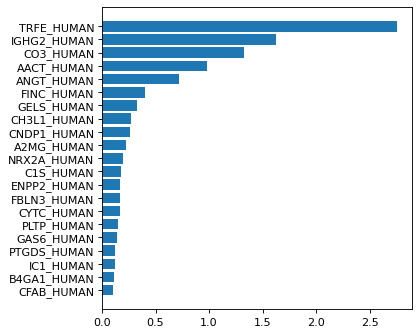

In [696]:
# Plotting the first 20 most iportant features for the DT model
figure(figsize=(5, 5), dpi=80)

plt.barh(list(feat_imp_score_aw_svm.keys())[20::-1], list(feat_imp_score_aw_svm.values())[20::-1])

#### Storing the ordered features in a dictionary

In [697]:
# Storing the results
for i, feat in enumerate(feat_imp_aw_svm, 1):
    if feat in feat_imp_svm.keys():
        feat_imp_svm[feat].append(i)
    else:
        feat_imp_svm[feat] = [i]

print(list(feat_imp_svm.items())[:3])

[('IBP7_HUMAN', [1, 479]), ('FETUA_HUMAN', [2, 503]), ('NBL1_HUMAN', [3, 330])]


### **- Decision Tree (DT)**

#### **Attributes' weights method**

In [698]:
feat_imp_score_aw_dt, feat_imp_aw_dt = feat_importance(dt_model, lisbon_coimbra_df, X, y, iterations=500)

98.0%


<BarContainer object of 21 artists>

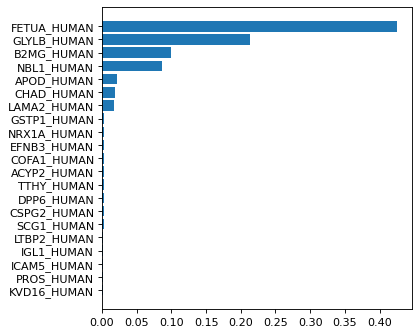

In [699]:
# Plotting the first 20 most iportant features for the DT model
figure(figsize=(5, 5), dpi=80)

plt.barh(list(feat_imp_score_aw_dt.keys())[20::-1], list(feat_imp_score_aw_dt.values())[20::-1])

#### Storing the ordered features in a dictionary

In [700]:
# Storing the results
for i, feat in enumerate(feat_imp_aw_dt, 1):
    if feat in feat_imp_dt.keys():
        feat_imp_dt[feat].append(i)
    else:
        feat_imp_dt[feat] = [i]

print(list(feat_imp_dt.items())[:3])

[('FETUA_HUMAN', [1, 1]), ('CFAI_HUMAN', [2, 306]), ('FBLN2_HUMAN', [3, 396])]


### **- Random Forest (RF)**

#### Attributes' weights method

In [701]:
feat_imp_score_aw_rf, feat_imp_aw_rf = feat_importance(rf_model, lisbon_coimbra_df, X, y, iterations=500)

98.0%


<BarContainer object of 21 artists>

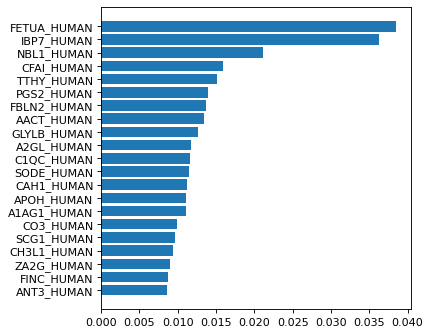

In [702]:
# Plotting the first 20 most iportant features for the DT model
figure(figsize=(5, 5), dpi=80)

plt.barh(list(feat_imp_score_aw_rf.keys())[20::-1], list(feat_imp_score_aw_rf.values())[20::-1])

#### Storing the ordered features in a dictionary

In [703]:
# Storing the results
for i, feat in enumerate(feat_imp_aw_rf, 1):
    if feat in feat_imp_rf.keys():
        feat_imp_rf[feat].append(i)
    else:
        feat_imp_rf[feat] = [i]

print(list(feat_imp_rf.items())[:3])

[('CFAI_HUMAN', [1, 4]), ('FETUA_HUMAN', [2, 1]), ('FBLN2_HUMAN', [3, 7])]


### **- XGBoost (XGB)**

#### Attributes' weights method

In [704]:
feat_imp_score_aw_xgb, feat_imp_aw_xgb = feat_importance(xgb_model, lisbon_coimbra_df, X, y, iterations=500)

98.0%


<BarContainer object of 21 artists>

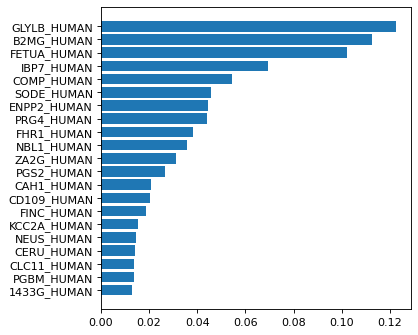

In [705]:
# Plotting the first 20 most iportant features for the DT model
figure(figsize=(5, 5), dpi=80)

plt.barh(list(feat_imp_score_aw_xgb.keys())[20::-1], list(feat_imp_score_aw_xgb.values())[20::-1])

#### Storing the ordered features in a dictionary

In [706]:
# Storing the results
for i, feat in enumerate(feat_imp_aw_xgb, 1):
    if feat in feat_imp_xgb.keys():
        feat_imp_xgb[feat].append(i)
    else:
        feat_imp_xgb[feat] = [i]

print(list(feat_imp_xgb.items())[:3])

[('CFAI_HUMAN', [1, 27]), ('FETUA_HUMAN', [2, 3]), ('FBLN2_HUMAN', [3, 308])]


### **- Linear Discriminant Analysis (LDA)**

#### Attributes' weights method

In [707]:
feat_imp_score_aw_lda, feat_imp_aw_lda = coef_feat(lda_model, lisbon_coimbra_df, X, y, iterations=500)

98.0%


<BarContainer object of 21 artists>

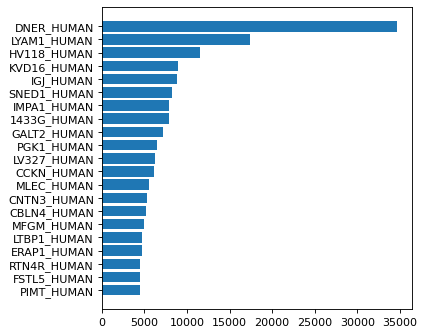

In [708]:
# Plotting the first 20 most iportant features for the DT model
figure(figsize=(5, 5), dpi=80)

plt.barh(list(feat_imp_score_aw_lda.keys())[20::-1], list(feat_imp_score_aw_lda.values())[20::-1])

#### Storing the ordered features in a dictionary

In [709]:
# Storing the results
for i, feat in enumerate(feat_imp_aw_lda, 1):
    if feat in feat_imp_lda.keys():
        feat_imp_lda[feat].append(i)
    else:
        feat_imp_lda[feat] = [i]

print(list(feat_imp_lda.items())[:3])

[('FETUA_HUMAN', [1, 403]), ('IBP7_HUMAN', [2, 471]), ('NBL1_HUMAN', [3, 512])]


### **- Ridge (RDG)**

#### Attributes' weights method

In [710]:
feat_imp_score_aw_rdg, feat_imp_aw_rdg = coef_feat(rdg_model, lisbon_coimbra_df, X, y, iterations=100)

90.0%


<BarContainer object of 21 artists>

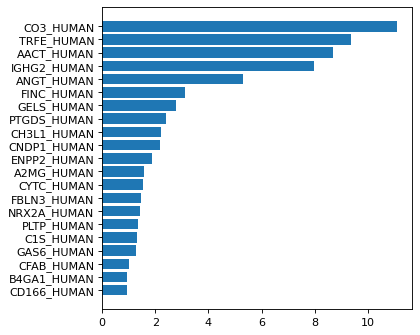

In [711]:
# Plotting the first 20 most iportant features for the DT model
figure(figsize=(5, 5), dpi=80)

plt.barh(list(feat_imp_score_aw_rdg.keys())[20::-1], list(feat_imp_score_aw_rdg.values())[20::-1])

#### Storing the ordered features in a dictionary

In [712]:
# Storing the results
for i, feat in enumerate(feat_imp_aw_rdg, 1):
    if feat in feat_imp_rdg.keys():
        feat_imp_rdg[feat].append(i)
    else:
        feat_imp_rdg[feat] = [i]

print(list(feat_imp_rdg.items())[:3])

[('TTHY_HUMAN', [1, 517]), ('CO3_HUMAN', [2, 1]), ('ALBU_HUMAN', [3, 493])]


### **- Logistic Regression (LR)**

#### Attributes' weights method

In [713]:
feat_imp_score_aw_lr, feat_imp_aw_lr = coef_feat(lr_model, lisbon_coimbra_df, X, y, iterations=500)

98.0%


<BarContainer object of 21 artists>

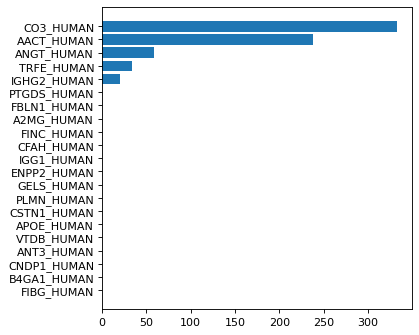

In [714]:
# Plotting the first 20 most iportant features for the DT model
figure(figsize=(5, 5), dpi=80)

plt.barh(list(feat_imp_score_aw_lr.keys())[20::-1], list(feat_imp_score_aw_lr.values())[20::-1])

#### Storing the ordered features in a dictionary

In [715]:
# Storing the results
for i, feat in enumerate(feat_imp_aw_lr, 1):
    if feat in feat_imp_lr.keys():
        feat_imp_lr[feat].append(i)
    else:
        feat_imp_lr[feat] = [i]

print(list(feat_imp_lr.items())[:3])

[('FETUA_HUMAN', [1, 161]), ('AACT_HUMAN', [2, 2]), ('CO3_HUMAN', [3, 1])]


## **4. Decrease of Accuracy**  

Computes the k-fold cross validation accuracy using all the features, than, remove one feature at a time and recompute the accuracy. The bigger is the difference from the base accuracy and the accuracy after removing a feature, the more relevant is the feature.

### ***Defining the functions that I will use***

In [716]:
def cross_validate_balancing(estimator, X, y, folds=10): 

    cv = StratifiedKFold(n_splits = folds, shuffle = True) # Stratified split
    scores = {\
            'auc':[], \
            'accuracy': [], \
            'f1': [], \
            'precision': [], \
            'recall': []}
    
    for train_idx, test_idx in cv.split(X, y): 
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        # if balance != 'None':
        #     X_train, y_train = balance.fit_resample(X_train, y_train)

        estimator.fit(X_train, y_train)
        y_predicted = estimator.predict(X_test)

        scores['auc'].append(roc_auc_score(y_test, y_predicted))
        scores['accuracy'].append(accuracy_score(y_test, y_predicted))
        scores['f1'].append(f1_score(y_test, y_predicted))
        scores['precision'].append(precision_score(y_test, y_predicted))
        scores['recall'].append(recall_score(y_test, y_predicted))

    return scores

In [717]:
def cv_iteration(model, X, y, iterations=10, folds=10):
    
    # Defining the final dictionary that will contain the scores
    iter_result = {}

    for _ in range(iterations):
        result = cross_validate_balancing(model, X, y, folds=folds) 
        result = {k: np.mean(v) for k, v in result.items()}

        # Filling the dictionary with the resuts obtained WITHOUT applying SMOTE
        for k, v in result.items():
            if k in iter_result.keys():
                iter_result[k].append(v)
            else:
                iter_result[k] = [v]
    
    # Computing the standard deviation
    sd_dict = {}
    for k, v in iter_result.items():
        sd_dict[k] = np.std(v)  

    iter_result = {k: np.mean(v) for k, v in iter_result.items()}
    
    return iter_result

In [718]:
def rec_feat_add(dataset, model, all_feat_auc, iterations=10, folds=10):

    feat_list = list(dataset.columns)

    dataset_one_feat = dataset

    feat_imp_score_rfa = {}

    for i, feat in enumerate(feat_list):

        print(f'{i/len(feat_list) * 100:.0f} %')
        clear_output(wait=True)

        # Dropping the feature
        dataset_one_feat = dataset_one_feat.drop(feat, axis=1)
        X_one_feat_less = dataset_one_feat.values

        # Cross validate the model 
        result_cv = cv_iteration(model, X_one_feat_less, y, iterations=iterations, folds=folds)
        
        # Computing the score of the feature
        score_diff = all_feat_auc - result_cv['auc']

        # print(f'all: {all_feat_auc} - This {result_cv["auc"]} - diff {score_diff}')

        feat_imp_score_rfa[feat] = score_diff

        # Re-adding the feature dropped
        dataset_one_feat = dataset

    feat_imp_score_rfa = dict(sorted(feat_imp_score_rfa.items(), key=lambda x: x[1], reverse=True))

    feat_imp_score_rfa_df = pd.DataFrame(list(feat_imp_score_rfa.items()), columns=['prot_code', 'score difference'])

    print('The AUC score of the model trained with all the features is:', all_feat_auc)

    return feat_imp_score_rfa_df

### **- Support Vector Machine (SVM)**

In [719]:
# Obtaining the score from the model trained with all the features
all_feat_svm_scores = cv_iteration(svm_model, X, y, iterations=10, folds=10)
# Extracting the AUC score from the obtained result
all_feat_auc_svm = all_feat_svm_scores['auc']

# Recursive Feature Addition 
feat_imp_score_da_svm = rec_feat_add(lisbon_coimbra_df, svm_model, all_feat_auc_svm, iterations=10, folds=10)

The AUC score of the model trained with all the features is: 0.49511904761904757


In [720]:
# Printing the sorted best features for which once removed, the difference in score was higher
feat_imp_score_da_svm

,prot_code,score difference
0,CA2D2_HUMAN,0.009405
1,NPTXR_HUMAN,0.007286
2,KVD21_HUMAN,0.006429
3,LDHB_HUMAN,0.005690
4,C1RL_HUMAN,0.005095
...,...,...
512,LG3BP_HUMAN,-0.009976
513,FBLN4_HUMAN,-0.010262
514,G3P_HUMAN,-0.010381
515,NBL1_HUMAN,-0.010738


In [721]:
# for idx in feat_imp_score_da_svm.index:
#     print(idx)
#     print(feat_imp_score_da_svm.loc[idx, :])

#### Storing the ordered features in a dictionary

In [722]:
# Storing the ordered features
for i, feat in enumerate(list(feat_imp_score_da_svm['prot_code']), 1):
    if feat in feat_imp_svm.keys():
        feat_imp_svm[feat].append(i)
    else:
        feat_imp_svm[feat] = [i]

print(list(feat_imp_svm.items())[:3])

[('IBP7_HUMAN', [1, 479, 305]), ('FETUA_HUMAN', [2, 503, 113]), ('NBL1_HUMAN', [3, 330, 516])]


### **- Decision Tree (DT)**

In [723]:
# Obtaining the score from the model trained with all the features
all_feat_dt_scores = cv_iteration(dt_model, X, y, iterations=10, folds=10)
# Extracting the AUC score from the obtained result
all_feat_auc_dt = all_feat_dt_scores['auc']

# Recursive Feature Addition 
feat_imp_score_da_dt = rec_feat_add(lisbon_coimbra_df, dt_model, all_feat_auc_dt, iterations=10, folds=10)

The AUC score of the model trained with all the features is: 0.7687619047619048


In [724]:
# Printing the sorted best features for which once removed the difference in score was higher
feat_imp_score_da_dt

,prot_code,score difference
0,FETUA_HUMAN,0.025405
1,LAMA2_HUMAN,0.020524
2,SEM3G_HUMAN,0.012452
3,RGMB_HUMAN,0.011833
4,CSPG2_HUMAN,0.011429
...,...,...
512,NCAN_HUMAN,-0.036190
513,NAR3_HUMAN,-0.038452
514,IBP7_HUMAN,-0.039452
515,CFAD_HUMAN,-0.043214


#### Storing the ordered features in the dictionary

In [725]:
for i, feat in enumerate(list(feat_imp_score_da_dt['prot_code']), 1):
    if feat in feat_imp_dt.keys():
        feat_imp_dt[feat].append(i)
    else:
        feat_imp_dt[feat] = [i]

print(list(feat_imp_dt.items())[:3])

[('FETUA_HUMAN', [1, 1, 1]), ('CFAI_HUMAN', [2, 306, 394]), ('FBLN2_HUMAN', [3, 396, 281])]


### **- Random Forest (RF)**

In [726]:
# Obtaining the score from the model trained with all the features
all_feat_rf_scores = cv_iteration(rf_model, X, y, iterations=10, folds=10)
# Extracting the AUC score from the obtained result
all_feat_auc_rf = all_feat_rf_scores['auc']

# Recursive Feature Addition 
feat_imp_score_da_rf = rec_feat_add(lisbon_coimbra_df, rf_model, all_feat_auc_rf, iterations=10, folds=10)

The AUC score of the model trained with all the features is: 0.9228809523809524


In [727]:
# Printing the sorted best features for which once removed the difference in score was higher
feat_imp_score_da_rf

,prot_code,score difference
0,KCC2B_HUMAN,0.013381
1,FRS1L_HUMAN,0.011238
2,CHRD_HUMAN,0.008738
3,C163A_HUMAN,0.008333
4,MDHC_HUMAN,0.007762
...,...,...
512,LAMC1_HUMAN,-0.012357
513,LDHB_HUMAN,-0.012810
514,ENOA_HUMAN,-0.013571
515,EGFLA_HUMAN,-0.013714


#### Storing the ordered features in the dictionary

In [728]:
for i, feat in enumerate(list(feat_imp_score_da_rf['prot_code']), 1):
    if feat in feat_imp_rf.keys():
        feat_imp_rf[feat].append(i)
    else:
        feat_imp_rf[feat] = [i]

print(list(feat_imp_rf.items())[:3])

[('CFAI_HUMAN', [1, 4, 333]), ('FETUA_HUMAN', [2, 1, 8]), ('FBLN2_HUMAN', [3, 7, 75])]


### **- XGBoost (XGB)**

In [729]:
# Obtaining the score from the model trained with all the features
all_feat_xgb_scores = cv_iteration(xgb_model, X, y, iterations=10, folds=10)
# Extracting the AUC score from the obtained result
all_feat_auc_xgb = all_feat_xgb_scores['auc']

# Recursive Feature Addition 
feat_imp_score_da_xgb = rec_feat_add(lisbon_coimbra_df, xgb_model, all_feat_auc_xgb, iterations=10, folds=10)

The AUC score of the model trained with all the features is: 0.8965476190476191


In [730]:
# Printing the sorted best features for which once removed the difference in score was higher
feat_imp_score_da_xgb

,prot_code,score difference
0,FETUA_HUMAN,0.027905
1,TIMP2_HUMAN,0.018095
2,GLYLB_HUMAN,0.016786
3,XYLT1_HUMAN,0.015690
4,AP2B1_HUMAN,0.015476
...,...,...
512,OSTP_HUMAN,-0.011548
513,SEM3G_HUMAN,-0.012452
514,AATM_HUMAN,-0.012952
515,CNTN1_HUMAN,-0.013381


#### Storing the ordered features in the dictionary

In [731]:
for i, feat in enumerate(list(feat_imp_score_da_xgb['prot_code']), 1):
    if feat in feat_imp_xgb.keys():
        feat_imp_xgb[feat].append(i)
    else:
        feat_imp_xgb[feat] = [i]

print(list(feat_imp_xgb.items())[:3])

[('CFAI_HUMAN', [1, 27, 63]), ('FETUA_HUMAN', [2, 3, 1]), ('FBLN2_HUMAN', [3, 308, 317])]


### **- Linear Discriminant Analysis (LDA)**

In [732]:
# Obtaining the score from the model trained with all the features
all_feat_lda_scores = cv_iteration(lda_model, X, y, iterations=10, folds=10)
# Extracting the AUC score from the obtained result
all_feat_auc_lda = all_feat_lda_scores['auc']

# Recursive Feature Addition 
feat_imp_score_da_lda = rec_feat_add(lisbon_coimbra_df, lda_model, all_feat_auc_lda, iterations=10, folds=10)

The AUC score of the model trained with all the features is: 0.8591190476190477


In [733]:
# Printing the sorted best features for which once removed the difference in score was higher
feat_imp_score_da_lda

,prot_code,score difference
0,CHAD_HUMAN,0.028405
1,NPC2_HUMAN,0.028262
2,IGHG3_HUMAN,0.027071
3,FETUA_HUMAN,0.026857
4,VTNC_HUMAN,0.026762
...,...,...
512,MUC18_HUMAN,-0.001833
513,APOL1_HUMAN,-0.001976
514,DPP6_HUMAN,-0.002000
515,PHLD_HUMAN,-0.002071


#### Storing the ordered features in the dictionary

In [734]:
for i, feat in enumerate(list(feat_imp_score_da_lda['prot_code']), 1):
    if feat in feat_imp_lda.keys():
        feat_imp_lda[feat].append(i)
    else:
        feat_imp_lda[feat] = [i]

print(list(feat_imp_lda.items())[:3])

[('FETUA_HUMAN', [1, 403, 4]), ('IBP7_HUMAN', [2, 471, 37]), ('NBL1_HUMAN', [3, 512, 58])]


### **- Ridge (RDG)**

In [735]:
# Obtaining the score from the model trained with all the features
all_feat_rdg_scores = cv_iteration(rdg_model, X, y, iterations=10, folds=10)
# Extracting the AUC score from the obtained result
all_feat_auc_rdg = all_feat_rdg_scores['auc']

# Recursive Feature Addition 
feat_imp_score_da_rdg = rec_feat_add(lisbon_coimbra_df, rdg_model, all_feat_auc_rdg, iterations=10, folds=10)

The AUC score of the model trained with all the features is: 0.7821428571428573


In [736]:
# Printing the sorted best features for which once removed the difference in score was higher
feat_imp_score_da_rdg

,prot_code,score difference
0,TTHY_HUMAN,0.076381
1,CO3_HUMAN,0.028190
2,TRFE_HUMAN,0.028119
3,AACT_HUMAN,0.023976
4,CO5_HUMAN,0.015119
...,...,...
512,A1AT_HUMAN,-0.013667
513,IGK_HUMAN,-0.014167
514,RET4_HUMAN,-0.015024
515,PGRP2_HUMAN,-0.018524


#### Storing the ordered features in the dictionary

In [737]:
for i, feat in enumerate(list(feat_imp_score_da_rdg['prot_code']), 1):
    if feat in feat_imp_rdg.keys():
        feat_imp_rdg[feat].append(i)
    else:
        feat_imp_rdg[feat] = [i]

print(list(feat_imp_rdg.items())[:3])

[('TTHY_HUMAN', [1, 517, 1]), ('CO3_HUMAN', [2, 1, 2]), ('ALBU_HUMAN', [3, 493, 23])]


### **- Logistic Regression (LR)**

In [738]:
# Obtaining the score from the model trained with all the features
all_feat_lr_scores = cv_iteration(lr_model, X, y, iterations=10, folds=10)
# Extracting the AUC score from the obtained result
all_feat_auc_lr = all_feat_lr_scores['auc']

# Recursive Feature Addition 
feat_imp_score_da_lr = rec_feat_add(lisbon_coimbra_df, lr_model, all_feat_auc_lr, iterations=10, folds=10)

The AUC score of the model trained with all the features is: 0.8729047619047619


In [739]:
# Printing the sorted best features for which once removed the difference in score was higher
feat_imp_score_da_lr

,prot_code,score difference
0,APOA1_HUMAN,0.039405
1,CO3_HUMAN,0.037000
2,KCC2A_HUMAN,0.009310
3,SIAE_HUMAN,0.008976
4,HEMO_HUMAN,0.008786
...,...,...
512,VCAM1_HUMAN,-0.012333
513,GRIA4_HUMAN,-0.012452
514,FBLN5_HUMAN,-0.013143
515,CA2D1_HUMAN,-0.013667


#### Storing the ordered features in the dictionary

In [740]:
for i, feat in enumerate(list(feat_imp_score_da_lr['prot_code']), 1):
    if feat in feat_imp_lr.keys():
        feat_imp_lr[feat].append(i)
    else:
        feat_imp_lr[feat] = [i]

print(list(feat_imp_lr.items())[:3])

[('FETUA_HUMAN', [1, 161, 275]), ('AACT_HUMAN', [2, 2, 6]), ('CO3_HUMAN', [3, 1, 2])]


## **5. Recursive Feature Addition - RFA**  
Ranks the features based on the weights, but repeating the process N times, adding the best feature to the beginning of the rank.  
Given an external estimator that assigns weights to features, the goal of recursive feature addition (RFA) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the most important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached. 

### ***Defining the functions that I will use***

In [741]:
def feature_addition_with_feat_importance(model, Dataset, y):
    
    final_rank = []

    for i in range(len(Dataset.keys())):

        print(i)
        clear_output(wait=True)

        score_feat_imp = {}

        iteration = 15
        
        X = Dataset.values

        for _ in range(iteration):
            
            # y = np.array([1 if i == 'Amyloid-Positive' else 2 for i in lisbon_coimbra_df['Group']])
            # X = Dataset.values

            # Fitting the model
            model.fit(X, y)

            # Extracting the important features
            feat_imp = model.feature_importances_

            for idx, score in enumerate(feat_imp):
                if Dataset.keys()[idx] in score_feat_imp.keys():
                    score_feat_imp[Dataset.keys()[idx]].append(score)
                else:
                    score_feat_imp[Dataset.keys()[idx]] = [score]

        # print(score_feat_imp_nb)
        score_feat_imp = {k: np.mean(v) for k, v in score_feat_imp.items()}
        
        # Sorting
        features_sorted = dict(sorted(score_feat_imp.items(), key=lambda x: x[1], reverse=True))

        # print(features_svm_sorted)

        best_feat = list(features_sorted.keys())[0]

        final_rank.append(best_feat)

        Dataset = Dataset.drop(best_feat, axis=1)

    return final_rank

In [742]:
def feature_addition_with_coef_feat(model, Dataset, y):
    
    final_rank = []

    for i in range(len(Dataset.keys())):

        print(i)
        clear_output(wait=True)

        score_feat_imp = {}

        iteration = 15
        
        X = Dataset.values

        for _ in range(iteration):
            
            # y = np.array([1 if i == 'Amyloid-Positive' else 2 for i in lisbon_coimbra_df['Group']])
            # X = Dataset.values

            # Fitting the model
            model.fit(X, y)

            # Extracting the important features
            feat_imp = np.array(model.coef_)[0]

            for idx, score in enumerate(feat_imp):
                if Dataset.keys()[idx] in score_feat_imp.keys():
                    score_feat_imp[Dataset.keys()[idx]].append(score)
                else:
                    score_feat_imp[Dataset.keys()[idx]] = [score]

        # print(score_feat_imp_nb)
        score_feat_imp = {k: np.mean(v) for k, v in score_feat_imp.items()}
        
        # Sorting
        features_sorted = dict(sorted(score_feat_imp.items(), key=lambda x: x[1], reverse=True))

        # print(features_svm_sorted)

        best_feat = list(features_sorted.keys())[0]

        final_rank.append(best_feat)

        Dataset = Dataset.drop(best_feat, axis=1)

    return final_rank

### **- Linear Support Vector Machines (SVM)**

#### Recursive feature addition

In [743]:
feat_imp_score_rfa_svm = feature_addition_with_coef_feat(svm_model, lisbon_coimbra_df, y)

516


In [744]:
# Printing the 10 best features
print(feat_imp_score_rfa_svm[:10])

['TRFE_HUMAN', 'IGHG2_HUMAN', 'CO3_HUMAN', 'AACT_HUMAN', 'ANGT_HUMAN', 'FINC_HUMAN', 'GELS_HUMAN', 'CH3L1_HUMAN', 'A2MG_HUMAN', 'CNDP1_HUMAN']


#### Storing the ordered features in the dictionary

In [745]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfa_svm, 1):
    if feat in feat_imp_svm.keys():
            feat_imp_svm[feat].append(i)
    else:
        feat_imp_svm[feat] = [i]

print(list(feat_imp_svm.items())[:3])

[('IBP7_HUMAN', [1, 479, 305, 477]), ('FETUA_HUMAN', [2, 503, 113, 502]), ('NBL1_HUMAN', [3, 330, 516, 331])]


### **- Decision Tree (DT)**

#### Recursive feature addition

In [746]:
feat_imp_score_rfa_dt = feature_addition_with_feat_importance(dt_model, lisbon_coimbra_df, y)

516


In [747]:
print(feat_imp_score_rfa_dt[:10])

['FETUA_HUMAN', 'IBP7_HUMAN', 'NBL1_HUMAN', 'CFAI_HUMAN', 'APOA1_HUMAN', 'A2GL_HUMAN', 'NRP2_HUMAN', 'CAH1_HUMAN', 'PGS2_HUMAN', 'SODE_HUMAN']


#### Storing the ordered features in the dictionary

In [748]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfa_dt, 1):
    if feat in feat_imp_dt.keys():
            feat_imp_dt[feat].append(i)
    else:
        feat_imp_dt[feat] = [i]

print(list(feat_imp_dt.items())[:3])

[('FETUA_HUMAN', [1, 1, 1, 1]), ('CFAI_HUMAN', [2, 306, 394, 4]), ('FBLN2_HUMAN', [3, 396, 281, 13])]


### **- Random Forest (RF)**

#### Recursive feature addition

In [749]:
feat_imp_score_rfa_rf = feature_addition_with_feat_importance(rf_model, lisbon_coimbra_df, y)

516


In [750]:
print(feat_imp_score_rfa_rf[:10])

['FETUA_HUMAN', 'IBP7_HUMAN', 'NBL1_HUMAN', 'TTHY_HUMAN', 'PGS2_HUMAN', 'CFAI_HUMAN', 'AACT_HUMAN', 'APOH_HUMAN', 'FBLN2_HUMAN', 'GLYLB_HUMAN']


#### Storing the ordered features in the dictionary

In [751]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfa_rf, 1):
    if feat in feat_imp_rf.keys():
            feat_imp_rf[feat].append(i)
    else:
        feat_imp_rf[feat] = [i]

print(list(feat_imp_rf.items())[:3])

[('CFAI_HUMAN', [1, 4, 333, 6]), ('FETUA_HUMAN', [2, 1, 8, 1]), ('FBLN2_HUMAN', [3, 7, 75, 9])]


### **- XGBoost (XGB)**

#### Recursive feature addition

In [752]:
feat_imp_score_rfa_xgb = feature_addition_with_feat_importance(xgb_model, lisbon_coimbra_df, y)

516


In [753]:
print(feat_imp_score_rfa_xgb[:10])

['GLYLB_HUMAN', 'FETUA_HUMAN', 'IBP7_HUMAN', 'GELS_HUMAN', 'NRP2_HUMAN', 'APOA1_HUMAN', 'EPHA4_HUMAN', 'ANT3_HUMAN', 'CAH1_HUMAN', 'CD109_HUMAN']


#### Storing the ordered features in the dictionary

In [754]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfa_xgb, 1):
    if feat in feat_imp_xgb.keys():
            feat_imp_xgb[feat].append(i)
    else:
        feat_imp_xgb[feat] = [i]

print(list(feat_imp_xgb.items())[:3])

[('CFAI_HUMAN', [1, 27, 63, 25]), ('FETUA_HUMAN', [2, 3, 1, 2]), ('FBLN2_HUMAN', [3, 308, 317, 33])]


### **- Linear Discriminant analysis (LDA)**

#### Recursive feature addition

In [755]:
feat_imp_score_rfa_lda = feature_addition_with_coef_feat(lda_model, lisbon_coimbra_df, y)

516


In [756]:
# Printing the 10 best features
print(feat_imp_score_rfa_lda[:10])

['DNER_HUMAN', 'LYAM1_HUMAN', 'HV118_HUMAN', 'IGJ_HUMAN', 'SNED1_HUMAN', 'KVD16_HUMAN', 'GALT2_HUMAN', 'IMPA1_HUMAN', 'PGK1_HUMAN', 'CBLN4_HUMAN']


#### Storing the ordered features in the dictionary

In [757]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfa_lda, 1):
    if feat in feat_imp_lda.keys():
            feat_imp_lda[feat].append(i)
    else:
        feat_imp_lda[feat] = [i]

print(list(feat_imp_lda.items())[:3])

[('FETUA_HUMAN', [1, 403, 4, 516]), ('IBP7_HUMAN', [2, 471, 37, 391]), ('NBL1_HUMAN', [3, 512, 58, 383])]


### **- Ridge (RDG)**

#### Recursive feature addition

In [758]:
feat_imp_score_rfa_rdg = feature_addition_with_coef_feat(rdg_model, lisbon_coimbra_df, y)

516


In [759]:
# Printing the 10 best features
print(feat_imp_score_rfa_rdg[:10])

['CO3_HUMAN', 'TRFE_HUMAN', 'AACT_HUMAN', 'ANGT_HUMAN', 'FINC_HUMAN', 'GELS_HUMAN', 'CNDP1_HUMAN', 'IGHG2_HUMAN', 'CH3L1_HUMAN', 'A2MG_HUMAN']


#### Storing the ordered features in the dictionary

In [760]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfa_rdg, 1):
    if feat in feat_imp_rdg.keys():
            feat_imp_rdg[feat].append(i)
    else:
        feat_imp_rdg[feat] = [i]

print(list(feat_imp_rdg.items())[:3])

[('TTHY_HUMAN', [1, 517, 1, 517]), ('CO3_HUMAN', [2, 1, 2, 1]), ('ALBU_HUMAN', [3, 493, 23, 509])]


### **- Logistic Regression (LR)**

#### Recursive feature addition

In [761]:
feat_imp_score_rfa_lr = feature_addition_with_coef_feat(lr_model, lisbon_coimbra_df, y)

516


In [762]:
# Printing the 10 best features
print(feat_imp_score_rfa_lr[:10])

['CO3_HUMAN', 'AACT_HUMAN', 'ANGT_HUMAN', 'GELS_HUMAN', 'ENPP2_HUMAN', 'PTGDS_HUMAN', 'FINC_HUMAN', 'TRFE_HUMAN', 'FBLN3_HUMAN', 'A2MG_HUMAN']


#### Storing the ordered features in the dictionary

In [763]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfa_lr, 1):
    if feat in feat_imp_lr.keys():
            feat_imp_lr[feat].append(i)
    else:
        feat_imp_lr[feat] = [i]

print(list(feat_imp_lr.items())[:3])

[('FETUA_HUMAN', [1, 161, 275, 160]), ('AACT_HUMAN', [2, 2, 6, 2]), ('CO3_HUMAN', [3, 1, 2, 1])]


## **6. Recursive Feature Elimination - RFE**      
Is similar to Recursive feature Addition, but instead of creating a rank from the best to the worst, it creates a rank by removing the worst feature from the train set and adding it to the end of the rank, repeating the process untill all features were ranked.

### ***Defining the functions that I will use***

In [764]:
def feature_elimination_with_feat_importance(model, Dataset, y):
    
    final_rank = []

    for i in range(len(Dataset.keys())):

        print(i)
        clear_output(wait=True)

        score_feat_imp = {}

        iteration = 15
        
        X = Dataset.values

        for _ in range(iteration):
            
            # y = np.array([1 if i == 'Amyloid-Positive' else 2 for i in lisbon_coimbra_df['Group']])
            # X = Dataset.values

            # Fitting the model
            model.fit(X, y)

            # Extracting the important features
            feat_imp = model.feature_importances_

            for idx, score in enumerate(feat_imp):
                if Dataset.keys()[idx] in score_feat_imp.keys():
                    score_feat_imp[Dataset.keys()[idx]].append(score)
                else:
                    score_feat_imp[Dataset.keys()[idx]] = [score]

        # print(score_feat_imp_nb)
        score_feat_imp = {k: np.mean(v) for k, v in score_feat_imp.items()}
        
        # Sorting
        features_sorted = dict(sorted(score_feat_imp.items(), key=lambda x: x[1], reverse=True))

        # print(features_svm_sorted)

        worst_feat = list(features_sorted.keys())[len(features_sorted) - 1]    

        final_rank.insert(0, worst_feat)

        Dataset = Dataset.drop(worst_feat, axis=1)

    return final_rank

In [765]:
def feature_elimination_with_coef_feat(model, Dataset, y):
    
    final_rank = []

    for i in range(len(Dataset.keys())):

        print(i)
        clear_output(wait=True)

        score_feat_imp = {}

        iteration = 15
        
        X = Dataset.values

        for _ in range(iteration):
            
            # y = np.array([1 if i == 'Amyloid-Positive' else 2 for i in lisbon_coimbra_df['Group']])
            # X = Dataset.values

            # Fitting the model
            model.fit(X, y)

            # Extracting the important features
            feat_imp = np.array(model.coef_)[0]

            for idx, score in enumerate(feat_imp):
                if Dataset.keys()[idx] in score_feat_imp.keys():
                    score_feat_imp[Dataset.keys()[idx]].append(score)
                else:
                    score_feat_imp[Dataset.keys()[idx]] = [score]

        # print(score_feat_imp_nb)
        score_feat_imp = {k: np.mean(v) for k, v in score_feat_imp.items()}
        
        # Sorting
        features_sorted = dict(sorted(score_feat_imp.items(), key=lambda x: x[1], reverse=True))

        # print(features_svm_sorted)

        worst_feat = list(features_sorted.keys())[len(features_sorted) - 1]    

        final_rank.insert(0, worst_feat)

        Dataset = Dataset.drop(worst_feat, axis=1)

    return final_rank

### **- Linear Support Vector Machines (SVM)**

#### Recursive feature elimination

In [766]:
feat_imp_score_rfe_svm = feature_elimination_with_coef_feat(svm_model, lisbon_coimbra_df, y)

516


In [767]:
# Printing the 10 best features
print(feat_imp_score_rfe_svm[:10])

['TRFE_HUMAN', 'IGHG2_HUMAN', 'CO3_HUMAN', 'AACT_HUMAN', 'ANGT_HUMAN', 'FINC_HUMAN', 'GELS_HUMAN', 'PTGDS_HUMAN', 'CNDP1_HUMAN', 'A2MG_HUMAN']


#### Storing the ordered features in the dictionary

In [768]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfe_svm, 1):
    if feat in feat_imp_svm.keys():
            feat_imp_svm[feat].append(i)
    else:
        feat_imp_svm[feat] = [i]

print(list(feat_imp_svm.items())[:3])

[('IBP7_HUMAN', [1, 479, 305, 477, 481]), ('FETUA_HUMAN', [2, 503, 113, 502, 503]), ('NBL1_HUMAN', [3, 330, 516, 331, 339])]


### **- Decision Tree (DT)**

#### Recursive feature elimination

In [769]:
feat_imp_score_rfe_dt = feature_elimination_with_feat_importance(dt_model, lisbon_coimbra_df, y)

516


In [770]:
print(feat_imp_score_rfe_dt[:10])

['FETUA_HUMAN', 'GLYLB_HUMAN', 'NBL1_HUMAN', 'B2MG_HUMAN', 'TTHY_HUMAN', 'LAMA2_HUMAN', 'B4GA1_HUMAN', 'CNDP1_HUMAN', 'APOD_HUMAN', 'NRX1A_HUMAN']


#### Storing the ordered features in the dictionary

In [771]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfe_dt, 1):
    if feat in feat_imp_dt.keys():
            feat_imp_dt[feat].append(i)
    else:
        feat_imp_dt[feat] = [i]

print(list(feat_imp_dt.items())[:3])

[('FETUA_HUMAN', [1, 1, 1, 1, 1]), ('CFAI_HUMAN', [2, 306, 394, 4, 137]), ('FBLN2_HUMAN', [3, 396, 281, 13, 297])]


### **- Random Forest (RF)**

#### Recursive feature elimination

In [772]:
feat_imp_score_rfe_rf = feature_elimination_with_feat_importance(rf_model, lisbon_coimbra_df, y)

516


In [773]:
print(feat_imp_score_rfe_rf[:10])

['FETUA_HUMAN', 'IBP7_HUMAN', 'NBL1_HUMAN', 'GLYLB_HUMAN', 'CFAI_HUMAN', 'FBLN2_HUMAN', 'PGS2_HUMAN', 'C1QC_HUMAN', 'CH3L1_HUMAN', 'AACT_HUMAN']


#### Storing the ordered features in the dictionary

In [774]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfe_rf, 1):
    if feat in feat_imp_rf.keys():
            feat_imp_rf[feat].append(i)
    else:
        feat_imp_rf[feat] = [i]

print(list(feat_imp_rf.items())[:3])

[('CFAI_HUMAN', [1, 4, 333, 6, 5]), ('FETUA_HUMAN', [2, 1, 8, 1, 1]), ('FBLN2_HUMAN', [3, 7, 75, 9, 6])]


### **- XGBoost (XGB)**

#### Recursive feature elimination

In [775]:
feat_imp_score_rfe_xgb = feature_elimination_with_feat_importance(xgb_model, lisbon_coimbra_df, y)

516


In [776]:
print(feat_imp_score_rfe_xgb[:10])

['FETUA_HUMAN', 'GLYLB_HUMAN', 'IBP7_HUMAN', 'CFAI_HUMAN', 'PRG4_HUMAN', 'NBL1_HUMAN', '1433G_HUMAN', 'COMP_HUMAN', 'FHR1_HUMAN', 'ENPP2_HUMAN']


#### Storing the ordered features in the dictionary

In [777]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfe_xgb, 1):
    if feat in feat_imp_xgb.keys():
            feat_imp_xgb[feat].append(i)
    else:
        feat_imp_xgb[feat] = [i]

print(list(feat_imp_xgb.items())[:3])

[('CFAI_HUMAN', [1, 27, 63, 25, 4]), ('FETUA_HUMAN', [2, 3, 1, 2, 1]), ('FBLN2_HUMAN', [3, 308, 317, 33, 308])]


### **- Linear Discriminant analysis (LDA)**

#### Recursive feature elimination

In [778]:
feat_imp_score_rfe_lda = feature_elimination_with_coef_feat(lda_model, lisbon_coimbra_df, y)

516


In [779]:
# Printing the 10 best features
print(feat_imp_score_rfe_lda[:10])

['IL6RB_HUMAN', 'PLTP_HUMAN', 'NID2_HUMAN', 'G3P_HUMAN', 'B2MG_HUMAN', 'CH3L1_HUMAN', 'TSP4_HUMAN', 'CATO_HUMAN', 'DPP6_HUMAN', 'CAD13_HUMAN']


#### Storing the ordered features in the dictionary

In [780]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfe_lda, 1):
    if feat in feat_imp_lda.keys():
            feat_imp_lda[feat].append(i)
    else:
        feat_imp_lda[feat] = [i]

print(list(feat_imp_lda.items())[:3])

[('FETUA_HUMAN', [1, 403, 4, 516, 272]), ('IBP7_HUMAN', [2, 471, 37, 391, 443]), ('NBL1_HUMAN', [3, 512, 58, 383, 511])]


### **- Ridge (RDG)**

#### Recursive feature elimination

In [781]:
feat_imp_score_rfe_rdg = feature_elimination_with_coef_feat(rdg_model, lisbon_coimbra_df, y)

516


In [782]:
# Printing the 10 best features
print(feat_imp_score_rfe_rdg[:10])

['CO3_HUMAN', 'IGHG2_HUMAN', 'TRFE_HUMAN', 'AACT_HUMAN', 'ANGT_HUMAN', 'FINC_HUMAN', 'GELS_HUMAN', 'CH3L1_HUMAN', 'CNDP1_HUMAN', 'NRX2A_HUMAN']


#### Storing the ordered features in the dictionary

In [783]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfe_rdg, 1):
    if feat in feat_imp_rdg.keys():
            feat_imp_rdg[feat].append(i)
    else:
        feat_imp_rdg[feat] = [i]

print(list(feat_imp_rdg.items())[:3])

[('TTHY_HUMAN', [1, 517, 1, 517, 517]), ('CO3_HUMAN', [2, 1, 2, 1, 1]), ('ALBU_HUMAN', [3, 493, 23, 509, 24])]


### **- Logistic Regression (LR)**

#### Recursive feature elimination

In [784]:
feat_imp_score_rfe_lr = feature_elimination_with_coef_feat(lr_model, lisbon_coimbra_df, y)

516


In [785]:
# Printing the 10 best features
print(feat_imp_score_rfe_lr[:10])

['FINC_HUMAN', 'CO3_HUMAN', 'IGHG2_HUMAN', 'AACT_HUMAN', 'TRFE_HUMAN', 'ANGT_HUMAN', 'ALBU_HUMAN', 'PTGDS_HUMAN', 'FBLN1_HUMAN', 'A2MG_HUMAN']


#### Storing the ordered features in the dictionary

In [786]:
# Storing the ordered features
for i, feat in enumerate(feat_imp_score_rfe_lr, 1):
    if feat in feat_imp_lr.keys():
            feat_imp_lr[feat].append(i)
    else:
        feat_imp_lr[feat] = [i]

print(list(feat_imp_lr.items())[:3])

[('FETUA_HUMAN', [1, 161, 275, 160, 507]), ('AACT_HUMAN', [2, 2, 6, 2, 4]), ('CO3_HUMAN', [3, 1, 2, 1, 2])]


# $\color{blue}{\text{Aggregation of the ranks by each model}}$

### ***Defining the function that I will use***    

The aggregator method that I will use is the **Average Rank Method**.  
The integer position of alternatives in rankings are averaged to calculate scores corresponding to alternatives, which are then sorted in ascending order to create a consensus ranking.  
Give $k$ full rankings $R_1, R_2, ..., R_k$ for each alternative $a \in R_i$, alternative $a$ is first assigned a score $A_i(a) = $, which is the position of alternative $a$ in the ranking $R_i$.  
Next, the positions of alternative $a$ in the rankings are averaged as: $\frac{1}{k} \sum^{k}_{i=1}A_i (a)$.  
The aggregated ranking is then created by sorting the alternatives in ascending order based on their average rank. 

In [787]:
def aggregator(feat_imp_dict):

    mean_pos_dict = {}

    for feat, pos in feat_imp_dict.items():
        # Computing the mean of each of the feat position
        mean_pos_dict[feat] = np.mean(pos)
    
    # Sort the new mean positions
    sorted_mean_pos_dict = dict(sorted(mean_pos_dict.items(), key=lambda x: x[1]))

    # Store the results in a dataframe
    sorted_mean_pos_df = pd.DataFrame(list(sorted_mean_pos_dict.values()), columns=['Pos_mean'], index=list(sorted_mean_pos_dict.keys()))

    return sorted_mean_pos_df

In [788]:
# Normalizing the ranks positions between 0 and 1
def position_normalizer(feat_imp_dict):

    feat_imp_norm_dict = {}
    for feat, list_pos in feat_imp_dict.items():
        norm_pos_list = []
        for pos in list_pos:
            norm_pos = (pos - 1) / (517 - 1) # (xi - min(x) / max(x) - min(x))
            norm_pos_list.append(norm_pos)
        feat_imp_norm_dict[feat] = norm_pos_list
    
    return feat_imp_norm_dict 

In [789]:
total_feat_ranks = pd.DataFrame(index=list(lisbon_coimbra_df.columns)) #columns=list(models_dict.keys()), 

## **One model at the time**

### **- Support Vector Machine - SVM**

#### *Before the aggregator*

In [790]:
# Defining the name of the columns (the name of the ranking methods)
col_name = ['Single Score', 'Attributes weights', 'Decrease of Accuracy', 'Recursive Feature Addition', 'Recursive Feature Elimination']

# converting the dictionary into a dataframe 
feat_imp_svm_df = pd.DataFrame.from_dict(feat_imp_svm, orient='index', columns=col_name)

# printing the first 10
feat_imp_svm_df[:10]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
IBP7_HUMAN,1,479,305,477,481
FETUA_HUMAN,2,503,113,502,503
NBL1_HUMAN,3,330,516,331,339
TTHY_HUMAN,4,517,40,517,517
FINC_HUMAN,5,6,189,6,6
SCG1_HUMAN,6,433,12,433,439
PGS2_HUMAN,7,471,417,473,475
SODE_HUMAN,8,480,17,480,480
HRG_HUMAN,9,496,226,498,497
CH3L1_HUMAN,10,8,39,8,11


#### *After the aggregator*

In [791]:
feat_imp_mean_ranks_svm = aggregator(feat_imp_svm)

feat_imp_mean_ranks_svm[:10]

,Pos_mean
CH3L1_HUMAN,15.2
FINC_HUMAN,42.4
HEP2_HUMAN,45.4
CO6A3_HUMAN,46.2
IC1_HUMAN,49.2
CO3_HUMAN,51.8
VASN_HUMAN,53.4
MEGF8_HUMAN,58.2
CNDP1_HUMAN,60.2
CO7_HUMAN,61.6


In [792]:
# feat_imp_norm_svm = position_normalizer(feat_imp_svm)

# feat_imp_mean_norm_ranks_svm = aggregator(feat_imp_norm_svm)

# feat_imp_mean_norm_ranks_svm[:10]

In [793]:
# Showing the score of the ranking methods for the first 10 features
feat_imp_svm_df.loc[list(feat_imp_mean_ranks_svm.index)[:10]]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
CH3L1_HUMAN,10,8,39,8,11
FINC_HUMAN,5,6,189,6,6
HEP2_HUMAN,57,39,66,33,32
CO6A3_HUMAN,36,45,48,47,55
IC1_HUMAN,87,19,102,18,20
CO3_HUMAN,18,3,232,3,3
VASN_HUMAN,45,71,6,69,76
MEGF8_HUMAN,176,31,15,35,34
CNDP1_HUMAN,118,9,155,10,9
CO7_HUMAN,126,30,95,29,28


#### Adding the sorted feature to the total ranks features

In [794]:
protein_list = list(total_feat_ranks.index)

list_to_append_svm = []

for prot in protein_list:
    pos = feat_imp_mean_ranks_svm.loc[prot, 'Pos_mean']
    list_to_append_svm.append(pos)

total_feat_ranks['SVM'] = list_to_append_svm

### **- Decision Tree - DT**

#### *Before the aggregator*

In [795]:
# Defining the name of the columns (the name of the ranking methods)
col_name = ['Single Score', 'Attributes weights', 'Decrease of Accuracy', 'Recursive Feature Addition', 'Recursive Feature Elimination']

# converting the dictionary into a dataframe 
feat_imp_dt_df = pd.DataFrame.from_dict(feat_imp_dt, orient='index', columns=col_name)

# printing the first 10
feat_imp_dt_df[:10]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
FETUA_HUMAN,1,1,1,1,1
CFAI_HUMAN,2,306,394,4,137
FBLN2_HUMAN,3,396,281,13,297
LV746_HUMAN,4,416,427,31,330
NRX2A_HUMAN,5,289,14,98,96
CAH1_HUMAN,6,232,354,8,331
CBPB2_HUMAN,7,362,202,70,242
TRFE_HUMAN,8,201,498,186,15
APOA1_HUMAN,9,204,210,5,27
1433G_HUMAN,10,100,235,75,446


#### *After the aggregator*

In [796]:
feat_imp_mean_ranks_dt = aggregator(feat_imp_dt)

feat_imp_mean_ranks_dt[:10]

,Pos_mean
FETUA_HUMAN,1.0
NBL1_HUMAN,20.2
TTHY_HUMAN,38.0
ZA2G_HUMAN,52.8
APOH_HUMAN,53.4
B2MG_HUMAN,58.4
FINC_HUMAN,67.2
CSPG2_HUMAN,74.8
SE6L1_HUMAN,77.6
PLTP_HUMAN,80.2


In [797]:
# Showing the score of the ranking methods for the first 10 features
feat_imp_dt_df.loc[list(feat_imp_mean_ranks_dt.index)[:10]]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
FETUA_HUMAN,1,1,1,1,1
NBL1_HUMAN,72,4,19,3,3
TTHY_HUMAN,69,13,77,26,5
ZA2G_HUMAN,45,26,159,20,14
APOH_HUMAN,25,103,90,21,28
B2MG_HUMAN,167,3,7,111,4
FINC_HUMAN,67,153,67,32,17
CSPG2_HUMAN,19,15,5,65,270
SE6L1_HUMAN,12,97,54,37,188
PLTP_HUMAN,38,77,135,30,121


#### Adding the sorted feature to the total ranks features

In [798]:
protein_list = list(total_feat_ranks.index)

list_to_append_dt = []

for prot in protein_list:
    pos = feat_imp_mean_ranks_dt.loc[prot, 'Pos_mean']
    list_to_append_dt.append(pos)

total_feat_ranks['DT'] = list_to_append_dt

### **- Random Forest - RF**

#### *Before the aggregator*

In [799]:
# Defining the name of the columns (the name of the ranking methods)
col_name = ['Single Score', 'Attributes weights', 'Decrease of Accuracy', 'Recursive Feature Addition', 'Recursive Feature Elimination']

# converting the dictionary into a dataframe 
feat_imp_rf_df = pd.DataFrame.from_dict(feat_imp_rf, orient='index', columns=col_name)

# printing the first 10
feat_imp_rf_df[:10]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
CFAI_HUMAN,1,4,333,6,5
FETUA_HUMAN,2,1,8,1,1
FBLN2_HUMAN,3,7,75,9,6
CAH1_HUMAN,4,13,504,14,17
LV746_HUMAN,5,48,127,47,58
NRX2A_HUMAN,6,131,372,147,99
APOA1_HUMAN,7,27,44,30,27
COL12_HUMAN,8,196,302,119,206
PIMT_HUMAN,9,112,233,105,106
TRFE_HUMAN,10,107,128,118,116


#### *After the aggregator*

In [800]:
feat_imp_mean_ranks_rf = aggregator(feat_imp_rf)

feat_imp_mean_ranks_rf[:10]

,Pos_mean
FETUA_HUMAN,2.6
IBP7_HUMAN,6.4
A2GL_HUMAN,13.6
NBL1_HUMAN,15.0
FBLN2_HUMAN,20.0
APOA1_HUMAN,27.0
C1QC_HUMAN,27.4
TTHY_HUMAN,27.4
PGS2_HUMAN,27.6
ZA2G_HUMAN,28.8


In [801]:
# Showing the score of the ranking methods for the first 10 features
feat_imp_rf_df.loc[list(feat_imp_mean_ranks_rf.index)[:10]]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
FETUA_HUMAN,2,1,8,1,1
IBP7_HUMAN,12,2,14,2,2
A2GL_HUMAN,23,10,12,11,12
NBL1_HUMAN,31,3,35,3,3
FBLN2_HUMAN,3,7,75,9,6
APOA1_HUMAN,7,27,44,30,27
C1QC_HUMAN,58,11,47,13,8
TTHY_HUMAN,90,5,25,4,13
PGS2_HUMAN,81,6,39,5,7
ZA2G_HUMAN,46,19,41,19,19


#### Adding the sorted feature to the total ranks features

In [802]:
protein_list = list(total_feat_ranks.index)

list_to_append_rf = []

for prot in protein_list:
    pos = feat_imp_mean_ranks_rf.loc[prot, 'Pos_mean']
    list_to_append_rf.append(pos)

total_feat_ranks['RF'] = list_to_append_rf

### **- XGBoost - XGB**

#### *Before the aggregator*

In [803]:
# Defining the name of the columns (the name of the ranking methods)
col_name = ['Single Score', 'Attributes weights', 'Decrease of Accuracy', 'Recursive Feature Addition', 'Recursive Feature Elimination']

# converting the dictionary into a dataframe 
feat_imp_xgb_df = pd.DataFrame.from_dict(feat_imp_xgb, orient='index', columns=col_name)

# printing the first 10
feat_imp_xgb_df[:10]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
CFAI_HUMAN,1,27,63,25,4
FETUA_HUMAN,2,3,1,2,1
FBLN2_HUMAN,3,308,317,33,308
CAH1_HUMAN,4,13,512,9,16
LV746_HUMAN,5,340,12,406,340
TRFE_HUMAN,6,44,109,37,44
NRX2A_HUMAN,7,123,464,22,123
IBP7_HUMAN,8,4,465,3,3
CBPB2_HUMAN,9,255,363,20,255
1433G_HUMAN,10,21,34,14,7


#### *After the aggregator*

In [804]:
feat_imp_mean_ranks_xgb = aggregator(feat_imp_xgb)

feat_imp_mean_ranks_xgb[:10]

,Pos_mean
FETUA_HUMAN,1.8
1433G_HUMAN,17.2
NBL1_HUMAN,19.0
CFAI_HUMAN,24.0
PGS2_HUMAN,30.4
COMP_HUMAN,31.8
GLYLB_HUMAN,34.8
SODE_HUMAN,35.6
TRFE_HUMAN,48.0
ITIH4_HUMAN,55.4


In [805]:
# Showing the score of the ranking methods for the first 10 features
feat_imp_xgb_df.loc[list(feat_imp_mean_ranks_xgb.index)[:10]]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
FETUA_HUMAN,2,3,1,2,1
1433G_HUMAN,10,21,34,14,7
NBL1_HUMAN,37,10,15,27,6
CFAI_HUMAN,1,27,63,25,4
PGS2_HUMAN,28,12,52,47,13
COMP_HUMAN,39,5,65,42,8
GLYLB_HUMAN,167,1,3,1,2
SODE_HUMAN,51,6,86,24,11
TRFE_HUMAN,6,44,109,37,44
ITIH4_HUMAN,68,68,55,18,68


#### Adding the sorted feature to the total ranks features

In [806]:
protein_list = list(total_feat_ranks.index)

list_to_append_xgb = []

for prot in protein_list:
    pos = feat_imp_mean_ranks_xgb.loc[prot, 'Pos_mean']
    list_to_append_xgb.append(pos)

total_feat_ranks['XGB'] = list_to_append_xgb

### **- Linear Discriminant Analysis (LDA)**

#### *Before the aggregator*

In [807]:
# Defining the name of the columns (the name of the ranking methods)
col_name = ['Single Score', 'Attributes weights', 'Decrease of Accuracy', 'Recursive Feature Addition', 'Recursive Feature Elimination']

# converting the dictionary into a dataframe 
feat_imp_lda_df = pd.DataFrame.from_dict(feat_imp_lda, orient='index', columns=col_name)

# printing the first 10
feat_imp_lda_df[:10]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
FETUA_HUMAN,1,403,4,516,272
IBP7_HUMAN,2,471,37,391,443
NBL1_HUMAN,3,512,58,383,511
SODE_HUMAN,4,413,259,371,311
AACT_HUMAN,5,237,85,462,21
CAH1_HUMAN,6,281,186,449,201
TTHY_HUMAN,7,276,77,505,57
CH3L1_HUMAN,8,161,61,447,6
SCG1_HUMAN,9,416,404,257,452
CO3_HUMAN,10,227,407,441,43


#### *After the aggregator*

In [808]:
feat_imp_mean_ranks_lda = aggregator(feat_imp_lda)

feat_imp_mean_ranks_lda[:10]

,Pos_mean
LYAM1_HUMAN,75.4
MMP2_HUMAN,75.8
LTBP1_HUMAN,101.0
CATO_HUMAN,101.2
KVD16_HUMAN,105.0
LCAT_HUMAN,111.4
CATF_HUMAN,114.6
PPIB_HUMAN,119.0
IL6RB_HUMAN,120.8
PGRP2_HUMAN,121.6


In [809]:
# Showing the score of the ranking methods for the first 10 features
feat_imp_svm_df.loc[list(feat_imp_mean_ranks_lda.index)[:10]]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
LYAM1_HUMAN,368,160,18,159,169
MMP2_HUMAN,104,65,474,59,63
LTBP1_HUMAN,329,287,335,282,288
CATO_HUMAN,480,270,201,285,286
KVD16_HUMAN,238,247,244,243,259
LCAT_HUMAN,183,99,504,92,89
CATF_HUMAN,103,51,408,81,58
PPIB_HUMAN,53,60,310,66,68
IL6RB_HUMAN,46,48,348,45,53
PGRP2_HUMAN,154,43,337,44,41


#### Adding the sorted feature to the total ranks features

In [810]:
protein_list = list(total_feat_ranks.index)

list_to_append_lda = []

for prot in protein_list:
    pos = feat_imp_mean_ranks_lda.loc[prot, 'Pos_mean']
    list_to_append_lda.append(pos)

total_feat_ranks['LDA'] = list_to_append_lda

### **- Ridge (RDG)**

#### *Before the aggregator*

In [811]:
# Defining the name of the columns (the name of the ranking methods)
col_name = ['Single Score', 'Attributes weights', 'Decrease of Accuracy', 'Recursive Feature Addition', 'Recursive Feature Elimination']

# converting the dictionary into a dataframe 
feat_imp_rdg_df = pd.DataFrame.from_dict(feat_imp_rdg, orient='index', columns=col_name)

# printing the first 10
feat_imp_rdg_df[:10]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
TTHY_HUMAN,1,517,1,517,517
CO3_HUMAN,2,1,2,1,1
ALBU_HUMAN,3,493,23,509,24
TRFE_HUMAN,4,2,3,2,3
HPT_HUMAN,5,515,6,516,514
HEMO_HUMAN,6,516,12,514,516
ANGT_HUMAN,7,5,56,4,5
AACT_HUMAN,8,3,4,3,4
NDRG2_HUMAN,9,95,226,115,108
SEPP1_HUMAN,10,161,283,155,169


#### *After the aggregator*

In [812]:
feat_imp_mean_ranks_rdg = aggregator(feat_imp_rdg)

feat_imp_mean_ranks_rdg[:10]

,Pos_mean
CO3_HUMAN,1.4
TRFE_HUMAN,2.8
AACT_HUMAN,4.4
ANGT_HUMAN,15.4
MRC2_HUMAN,42.4
CATF_HUMAN,61.4
DPP6_HUMAN,65.4
EPHA4_HUMAN,75.4
IGHG4_HUMAN,82.0
FBLN3_HUMAN,84.2


In [813]:
# Showing the score of the ranking methods for the first 10 features
feat_imp_rdg_df.loc[list(feat_imp_mean_ranks_rdg.index)[:10]]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
CO3_HUMAN,2,1,2,1,1
TRFE_HUMAN,4,2,3,2,3
AACT_HUMAN,8,3,4,3,4
ANGT_HUMAN,7,5,56,4,5
MRC2_HUMAN,16,46,57,43,50
CATF_HUMAN,103,52,34,63,55
DPP6_HUMAN,65,42,138,38,44
EPHA4_HUMAN,100,58,99,61,59
IGHG4_HUMAN,112,47,146,65,40
FBLN3_HUMAN,283,14,96,11,17


#### Adding the sorted feature to the total ranks features

In [814]:
protein_list = list(total_feat_ranks.index)

list_to_append_rdg = []

for prot in protein_list:
    pos = feat_imp_mean_ranks_rdg.loc[prot, 'Pos_mean']
    list_to_append_rdg.append(pos)

total_feat_ranks['RDG'] = list_to_append_rdg

### **- Logistic Regression (LR)**

#### *Before the aggregator*

In [815]:
# Defining the name of the columns (the name of the ranking methods)
col_name = ['Single Score', 'Attributes weights', 'Decrease of Accuracy', 'Recursive Feature Addition', 'Recursive Feature Elimination']

# converting the dictionary into a dataframe 
feat_imp_lr_df = pd.DataFrame.from_dict(feat_imp_lr, orient='index', columns=col_name)

# printing the first 10
feat_imp_lr_df[:10]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
FETUA_HUMAN,1,161,275,160,507
AACT_HUMAN,2,2,6,2,4
CO3_HUMAN,3,1,2,1,2
TTHY_HUMAN,4,516,452,517,516
FINC_HUMAN,5,9,504,7,1
CH3L1_HUMAN,6,49,55,14,42
GELS_HUMAN,7,13,498,4,13
ANT3_HUMAN,8,18,78,21,514
A1AG1_HUMAN,9,94,97,93,509
ANGT_HUMAN,10,3,213,3,6


#### *After the aggregator*

In [816]:
feat_imp_mean_ranks_lr = aggregator(feat_imp_lr)

feat_imp_mean_ranks_lr[:10]

,Pos_mean
CO3_HUMAN,1.8
AACT_HUMAN,3.2
TRFE_HUMAN,10.4
CH3L1_HUMAN,33.2
ANGT_HUMAN,47.0
A2MG_HUMAN,51.4
CYTC_HUMAN,68.2
CNDP1_HUMAN,76.6
PLMN_HUMAN,95.4
NCHL1_HUMAN,96.4


In [817]:
# Showing the score of the ranking methods for the first 10 features
feat_imp_lr_df.loc[list(feat_imp_mean_ranks_lr.index)[:10]]

,Single Score,Attributes weights,Decrease of Accuracy,Recursive Feature Addition,Recursive Feature Elimination
CO3_HUMAN,3,1,2,1,2
AACT_HUMAN,2,2,6,2,4
TRFE_HUMAN,18,4,17,8,5
CH3L1_HUMAN,6,49,55,14,42
ANGT_HUMAN,10,3,213,3,6
A2MG_HUMAN,11,8,218,10,10
CYTC_HUMAN,23,55,205,11,47
CNDP1_HUMAN,19,19,317,12,16
PLMN_HUMAN,355,14,76,18,14
NCHL1_HUMAN,338,40,28,42,34


#### Adding the sorted feature to the total ranks features

In [818]:
protein_list = list(total_feat_ranks.index)

list_to_append_lr = []

for prot in protein_list:
    pos = feat_imp_mean_ranks_lr.loc[prot, 'Pos_mean']
    list_to_append_lr.append(pos)

total_feat_ranks['LR'] = list_to_append_lr

# $\color{blue}{\text{Aggregation of all the ranks from all the models}}$

In [819]:
total_feat_ranks[:10]

,SVM,DT,RF,XGB,LDA,RDG,LR
ALBU_HUMAN,442.6,258.0,273.0,145.0,249.4,210.4,276.2
TRFE_HUMAN,80.6,181.6,95.8,48.0,203.8,2.8,10.4
TTHY_HUMAN,319.0,38.0,27.4,88.0,184.4,310.6,401.0
PTGDS_HUMAN,133.0,214.6,412.2,226.8,349.2,147.0,169.8
FBLN1_HUMAN,429.4,195.6,314.6,265.4,302.8,399.4,109.8
CO3_HUMAN,51.8,92.4,105.2,86.4,225.6,1.4,1.8
A2MG_HUMAN,80.8,166.4,91.0,146.6,208.8,124.8,51.4
FINC_HUMAN,42.4,67.2,52.6,61.8,176.6,90.0,105.2
CFAH_HUMAN,354.4,194.6,257.2,187.6,263.6,413.8,127.0
IGG1_HUMAN,451.0,265.0,410.0,205.0,295.4,467.0,331.6


In [820]:
total_feat_mean_ranks = {}

for index in total_feat_ranks.index:
    # print(index)
    # print(np.mean(list(total_feat_ranks.loc[index, :])))
    total_feat_mean_ranks[index] = np.mean(list(total_feat_ranks.loc[index, :]))

# Sorting the features 
total_feat_mean_ranks = dict(sorted(total_feat_mean_ranks.items(), key=lambda x:x[1]))

total_feat_mean_ranks_df = pd.DataFrame(total_feat_mean_ranks.values(), index=total_feat_mean_ranks.keys(), columns=['mean_rank'])

total_feat_mean_ranks_df[:10]

,mean_rank
AACT_HUMAN,80.257143
CO3_HUMAN,80.657143
CH3L1_HUMAN,81.457143
FINC_HUMAN,85.114286
TRFE_HUMAN,89.000000
C1QC_HUMAN,110.314286
HEP2_HUMAN,113.342857
PLTP_HUMAN,113.371429
A2MG_HUMAN,124.257143
GLYLB_HUMAN,128.571429


In [821]:
# total_feat_mean_ranks_df.to_excel('Feature_rank_02.xlsx')

In [822]:
total_feat_ranks.loc[list(total_feat_mean_ranks_df.index)[:10]]

,SVM,DT,RF,XGB,LDA,RDG,LR
AACT_HUMAN,83.4,146.4,106.4,56.0,162.0,4.4,3.2
CO3_HUMAN,51.8,92.4,105.2,86.4,225.6,1.4,1.8
CH3L1_HUMAN,15.2,104.8,49.0,108.2,136.6,123.2,33.2
FINC_HUMAN,42.4,67.2,52.6,61.8,176.6,90.0,105.2
TRFE_HUMAN,80.6,181.6,95.8,48.0,203.8,2.8,10.4
C1QC_HUMAN,88.8,141.4,27.4,59.6,146.2,96.8,212.0
HEP2_HUMAN,45.4,127.4,90.4,88.4,156.8,164.6,120.4
PLTP_HUMAN,110.6,80.2,92.2,131.2,160.4,87.8,131.2
A2MG_HUMAN,80.8,166.4,91.0,146.6,208.8,124.8,51.4
GLYLB_HUMAN,86.4,120.2,51.8,34.8,176.0,145.4,285.4


# Training the models with the best features

In [823]:
def cv_one_feat_at_time(feature_importance_name, model, Dataset, X, y, n_iter=10, n_folds=10):

    # Generating the X_iter matrix that will contain the features added one at the time each iteration
    X_iter = [[] for i in range(len(X))]

    # Defining the final structure that will contain the results of the iterations
    final_score_iterations = {}

    # looping between the features and adding the feature to the X_iter every time
    for j, feature in enumerate(feature_importance_name):

        clear_output(wait=True)
        print(f'{((j/len(feature_importance_name))*100):.0f}%', end='     ')
        print(feature, end='     ')
        
        # print(feature)
        # Building the X_iter 
        for i, feat in enumerate(list(Dataset[feature])):
            X_iter[i].append(feat)
        
        print(f'The number of features is: {len(X_iter[0])}')

        result_iter = {}

        for _ in range(n_iter):
            results = cross_validate_balancing(model, np.array([np.array(xi) for xi in X_iter]), y, folds=n_folds) # balance='None' -> If you don't want SMOTE
            results = {k: np.mean(v) for k, v in results.items()}

            for key, value in results.items():
                if key in result_iter.keys(): 
                    result_iter[key].append(value)
                else:
                    result_iter[key] = [value]

        result_iter = {k: np.mean(v) for k, v in result_iter.items()}

        for key, value in result_iter.items():
            if key in final_score_iterations.keys():
                final_score_iterations[key].append(value)
            else:
                final_score_iterations[key] = [value]

    return final_score_iterations

In [824]:
def extract_most_imp_feat(Dataset, final_iteration_results, features_importance_name):
    # Finding the maximum value of AUC
    maximum = max(final_iteration_results['auc'])
    print(f'The maximum value of AUC obtained with this result is: {maximum}')

    # The number of features needed to obtain this maximum value of AUC
    pos = final_iteration_results['auc'].index(maximum) + 1
    print(f'The number of features needed to obtain this result is: {pos} \n')

    # Storing these best important features
    best_features = features_importance_name[:pos]
    # print(f'These features are: \n{best_features} \n')
    

    # Generating a new Dataset in which there will be only the best important features for the model
    lisbon_coimbra_important_features = pd.DataFrame()

    for feature in best_features:
        lisbon_coimbra_important_features[feature] = list(Dataset[feature])

    print(f'Dataset of {lisbon_coimbra_important_features.shape[0]} examples and {lisbon_coimbra_important_features.shape[1]} features \n')

    # Converting the Dataframe in a numpy array, that will be our X set:
    X_best_feat = lisbon_coimbra_important_features.values

    assert len(X_best_feat[0]) == lisbon_coimbra_important_features.shape[1]

    return lisbon_coimbra_important_features, X_best_feat

In [825]:
def cross_validate_balancing(estimator, X, y, folds=10): 
    #, balance = SMOTE()
    cv = StratifiedKFold(n_splits = folds, shuffle = True) # Stratified split
    scores = {\
            'auc':[], \
            'accuracy': [], \
            'f1': [], \
            'precision': [], \
            'recall': []}
    
    for train_idx, test_idx in cv.split(X,y): 
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        # if balance != 'None':
        #     X_train, y_train = balance.fit_resample(X_train, y_train)

        estimator.fit(X_train, y_train)
        y_predicted = estimator.predict(X_test)

        scores['auc'].append(roc_auc_score(y_test, y_predicted))
        scores['accuracy'].append(accuracy_score(y_test, y_predicted))
        scores['f1'].append(f1_score(y_test, y_predicted))
        scores['precision'].append(precision_score(y_test, y_predicted))
        scores['recall'].append(recall_score(y_test, y_predicted))

    return scores

In [826]:
def cv_iteration(model, X, y, iterations=10, folds=10):
    
    # Defining the final dictionary that will contain the scores
    iter_result = {}

    for _ in range(iterations):

        if _ % 2 == 0:
            # clear_output(wait=True)
            print(f'{(_/iterations)*100}%', end=' -> ')

        result = cross_validate_balancing(model, X, y, folds=folds) 
        result = {k: np.mean(v) for k, v in result.items()}

        # Filling the dictionary with the resuts obtained WITHOUT applying SMOTE
        for k, v in result.items():
            if k in iter_result.keys():
                iter_result[k].append(v)
            else:
                iter_result[k] = [v]
    
    # Computing the standard deviation
    sd_dict = {}
    for k, v in iter_result.items():
        sd_dict[k] = np.std(v)  

    iter_result = {k: np.mean(v) for k, v in iter_result.items()}

    return iter_result

## SVM

In [827]:
n_iter = 10
n_folds = 10

# Adding one feature at the time
iter_evaluation_res_svm = cv_one_feat_at_time(list(total_feat_mean_ranks_df.index), svm_model, lisbon_coimbra_df, X, y, n_iter=n_iter, n_folds=n_folds)

100%     MIA_HUMAN     The number of features is: 517


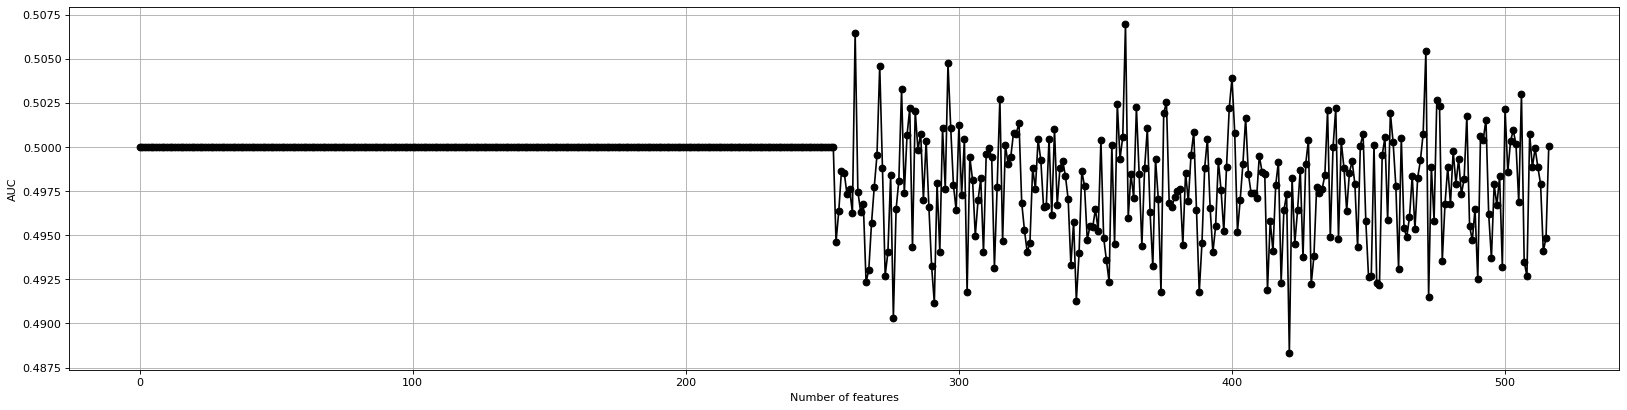

In [828]:
# Plotting the trend of the graph 
figure(figsize=(25, 6), dpi=80)

plt.plot(range(len(iter_evaluation_res_svm['auc'])), iter_evaluation_res_svm['auc'], '-ok')
plt.xlabel('Number of features')
plt.ylabel('AUC')

plt.grid()

plt.show()

## LDA

In [4]:
n_iter = 5
n_folds = 10

# Adding one feature at the time
iter_evaluation_res_lda = cv_one_feat_at_time(list(total_feat_mean_ranks_df.index), lda_model, lisbon_coimbra_df, X, y, n_iter=n_iter, n_folds=n_folds)

100%     MIA_HUMAN     The number of features is: 517


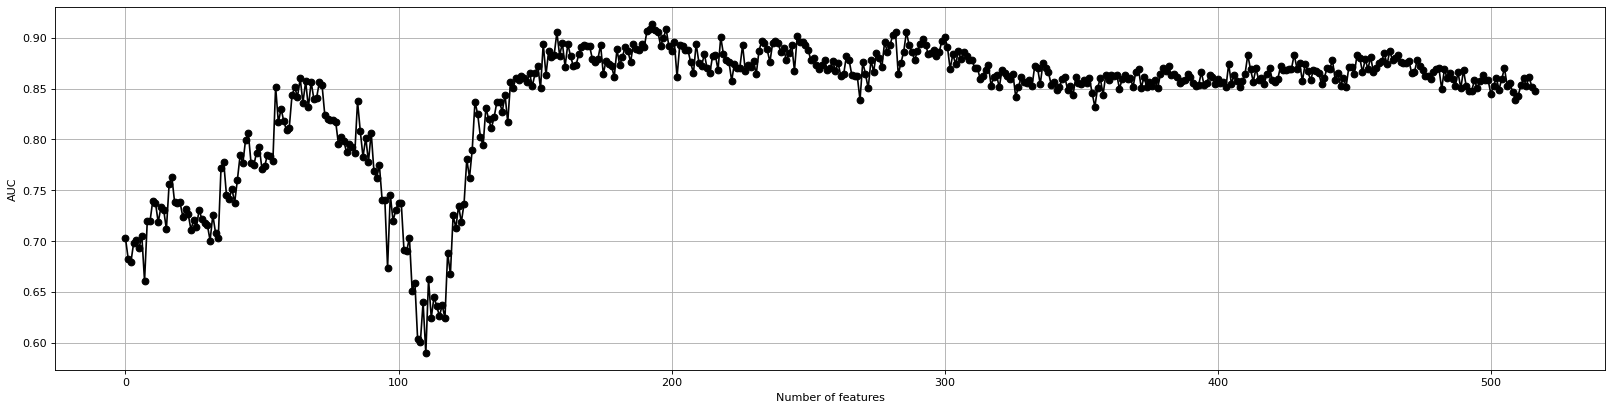

In [5]:
# Plotting the trend of the graph 
figure(figsize=(25, 6), dpi=80)

plt.plot(range(len(iter_evaluation_res_lda['auc'])), iter_evaluation_res_lda['auc'], '-ok')
plt.xlabel('Number of features')
plt.ylabel('AUC')

plt.grid()

plt.show()

## RDG

In [6]:
n_iter = 5
n_folds = 10

# Adding one feature at the time
iter_evaluation_res_rdg = cv_one_feat_at_time(list(total_feat_mean_ranks_df.index), rdg_model, lisbon_coimbra_df, X, y, n_iter=n_iter, n_folds=n_folds)

100%     MIA_HUMAN     The number of features is: 517


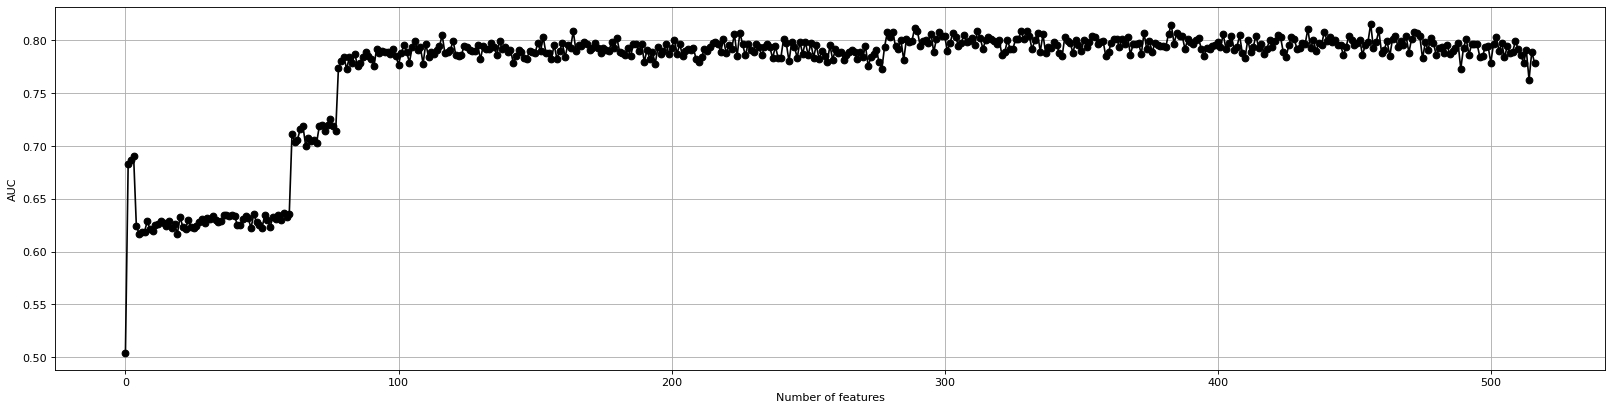

In [7]:
# Plotting the trend of the graph 
figure(figsize=(25, 6), dpi=80)

plt.plot(range(len(iter_evaluation_res_rdg['auc'])), iter_evaluation_res_rdg['auc'], '-ok')
plt.xlabel('Number of features')
plt.ylabel('AUC')

plt.grid()

plt.show()

In [8]:
# Recalling the above function to obtain the most important features for the RF classifier
only_best_feat_rdg, X_best_feat_rdg = extract_most_imp_feat(lisbon_coimbra_df, 
                                                            iter_evaluation_res_rdg, 
                                                            list(feat_imp_mean_ranks_rdg.index))

only_best_feat_rdg[:10]

The maximum value of AUC obtained with this result is: 0.8155714285714286
The number of features needed to obtain this result is: 457 

Dataset of 126 examples and 457 features 



,CO3_HUMAN,TRFE_HUMAN,AACT_HUMAN,ANGT_HUMAN,MRC2_HUMAN,CATF_HUMAN,DPP6_HUMAN,EPHA4_HUMAN,IGHG4_HUMAN,FBLN3_HUMAN,...,FIBG_HUMAN,IBP7_HUMAN,ROBO1_HUMAN,APOA1_HUMAN,IGSF8_HUMAN,ECM2_HUMAN,AMBP_HUMAN,NPTX1_HUMAN,KPYM_HUMAN,NAR3_HUMAN
0,0.012248,0.064232,0.009657,0.009635,0.000051,0.000188,0.000052,0.000189,0.001008,0.002903,...,0.001620,0.000264,0.000260,0.003949,0.000252,0.000136,0.000198,0.000408,0.001206,0.000172
1,0.018902,0.047139,0.010961,0.007108,0.000308,0.000146,0.000128,0.000063,0.003021,0.001353,...,0.003605,0.000197,0.000660,0.008794,0.000273,0.000224,0.000705,0.000243,0.000505,0.000164
2,0.012882,0.029375,0.014102,0.005649,0.000478,0.000115,0.000123,0.000137,0.000304,0.002138,...,0.001940,0.000267,0.000202,0.004362,0.000361,0.000371,0.000443,0.000397,0.000457,0.000208
3,0.018822,0.071905,0.017497,0.007037,0.000553,0.000119,0.000162,0.000149,0.000253,0.001774,...,0.006678,0.000200,0.000417,0.008399,0.000189,0.000122,0.000549,0.000775,0.000506,0.000221
4,0.014416,0.064845,0.011546,0.010766,0.000040,0.000085,0.000096,0.000230,0.004511,0.002694,...,0.004151,0.000304,0.000254,0.007418,0.000293,0.000188,0.000494,0.000481,0.000660,0.000236
5,0.015407,0.099774,0.011104,0.015172,0.000582,0.000171,0.000055,0.000236,0.001219,0.002387,...,0.003251,0.000254,0.000731,0.008759,0.000485,0.000204,0.000540,0.000657,0.000845,0.000226
6,0.022950,0.062658,0.019078,0.008346,0.000095,0.000066,0.000109,0.000109,0.000423,0.001862,...,0.003215,0.000291,0.000600,0.008959,0.000576,0.000143,0.000739,0.000506,0.000764,0.000239
7,0.017594,0.050341,0.014064,0.010450,0.000429,0.000164,0.000070,0.000239,0.002098,0.002909,...,0.004759,0.000423,0.000733,0.005730,0.000320,0.000140,0.000539,0.000954,0.000717,0.000247
8,0.012776,0.031451,0.010962,0.011131,0.000353,0.000063,0.000054,0.000177,0.001073,0.002089,...,0.002531,0.000348,0.000169,0.006505,0.000492,0.000130,0.000354,0.000452,0.000475,0.000159
9,0.010877,0.053369,0.009324,0.010682,0.000280,0.000072,0.000046,0.000301,0.000712,0.003029,...,0.001839,0.000256,0.000071,0.003723,0.000188,0.000174,0.000240,0.000557,0.000664,0.000160


## LR

In [9]:
n_iter = 5
n_folds = 10

# Adding one feature at the time
iter_evaluation_res_lr = cv_one_feat_at_time(list(total_feat_mean_ranks_df.index), lr_model, lisbon_coimbra_df, X, y, n_iter=n_iter, n_folds=n_folds)

100%     MIA_HUMAN     The number of features is: 517


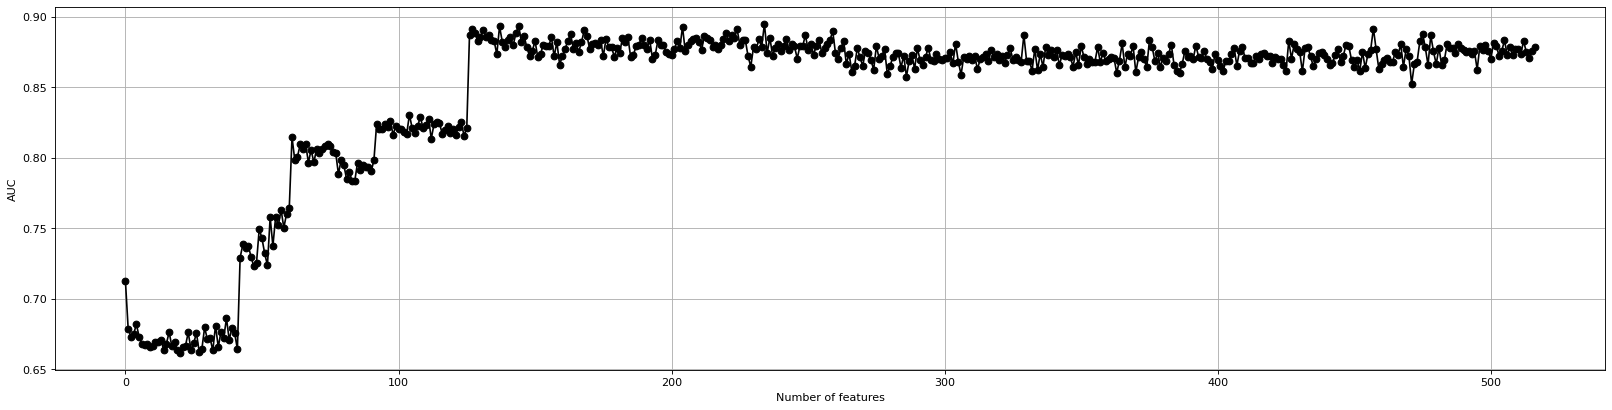

In [10]:
# Plotting the trend of the graph 
figure(figsize=(25, 6), dpi=80)

plt.plot(range(len(iter_evaluation_res_lr['auc'])), iter_evaluation_res_lr['auc'], '-ok')
plt.xlabel('Number of features')
plt.ylabel('AUC')

plt.grid()

plt.show()

In [11]:
# Recalling the above function to obtain the most important features for the RF classifier
only_best_feat_lr, X_best_feat_lr = extract_most_imp_feat(lisbon_coimbra_df, 
                                                            iter_evaluation_res_lr, 
                                                            list(feat_imp_mean_ranks_lr.index))

only_best_feat_lr[:10]

The maximum value of AUC obtained with this result is: 0.8948095238095239
The number of features needed to obtain this result is: 235 

Dataset of 126 examples and 235 features 



,CO3_HUMAN,AACT_HUMAN,TRFE_HUMAN,CH3L1_HUMAN,ANGT_HUMAN,A2MG_HUMAN,CYTC_HUMAN,CNDP1_HUMAN,PLMN_HUMAN,NCHL1_HUMAN,...,ERAP1_HUMAN,CBLN3_HUMAN,TIMP1_HUMAN,IGLC2_HUMAN,CATH_HUMAN,CYC_HUMAN,COCA1_HUMAN,APOC1_HUMAN,KVD37_HUMAN,PGK1_HUMAN
0,0.012248,0.009657,0.064232,0.000824,0.009635,0.004779,0.001219,0.004334,0.001469,0.001167,...,0.000041,0.000048,0.000195,9.882441e-06,0.000022,0.000008,0.000040,0.000487,0.000687,0.000030
1,0.018902,0.010961,0.047139,0.000638,0.007108,0.003778,0.000968,0.002826,0.001968,0.001323,...,0.000046,0.000023,0.000173,1.094674e-06,0.000068,0.000012,0.000179,0.000481,0.001880,0.000025
2,0.012882,0.014102,0.029375,0.001120,0.005649,0.003005,0.003420,0.004654,0.000902,0.000814,...,0.000031,0.000023,0.000177,5.555838e-05,0.000071,0.000014,0.000091,0.000378,0.000545,0.000022
3,0.018822,0.017497,0.071905,0.001598,0.007037,0.005564,0.002243,0.004435,0.002559,0.000859,...,0.000046,0.000067,0.000194,9.957138e-07,0.000118,0.000018,0.000103,0.000300,0.001059,0.000025
4,0.014416,0.011546,0.064845,0.001758,0.010766,0.004604,0.002792,0.005980,0.001344,0.001551,...,0.000027,0.000084,0.000250,1.489679e-05,0.000074,0.000013,0.000033,0.000476,0.001359,0.000047
5,0.015407,0.011104,0.099774,0.001739,0.015172,0.007085,0.005466,0.008486,0.002210,0.001456,...,0.000062,0.000094,0.000316,3.356095e-05,0.000022,0.000024,0.000054,0.000127,0.000140,0.000035
6,0.022950,0.019078,0.062658,0.001869,0.008346,0.006127,0.002272,0.004537,0.003609,0.001074,...,0.000029,0.000032,0.000244,4.276695e-05,0.000070,0.000011,0.000191,0.000693,0.001116,0.000033
7,0.017594,0.014064,0.050341,0.001048,0.010450,0.006193,0.001982,0.007339,0.002122,0.001361,...,0.000010,0.000051,0.000330,8.091451e-05,0.000026,0.000013,0.000030,0.000114,0.000966,0.000030
8,0.012776,0.010962,0.031451,0.001455,0.011131,0.004636,0.001532,0.006077,0.002571,0.001171,...,0.000027,0.000038,0.000165,1.515142e-05,0.000070,0.000017,0.000096,0.000150,0.001566,0.000010
9,0.010877,0.009324,0.053369,0.000939,0.010682,0.004307,0.003632,0.006458,0.001705,0.001310,...,0.000022,0.000048,0.000157,3.122480e-06,0.000057,0.000013,0.000029,0.000123,0.001152,0.000021


# **Selecting the top best features - test**

**Predictability**
It is assessed by combining Area Under the ROC Curve, Sensitivity and Specificity:

$predictability = \alpha AUC + \gamma F(sensitivit, specificity)$

Wher $\alpha$ and $\gamma$ (between [0; 1]) are parameters that control the importance given to AUC or to the value given by $F(sensitivit, specificity)$.   
$F$ is a generic function to combine sensitivity and specificity scores, which may be tailore to the purpose of the learning task. 

In [4]:
total_feat_mean_ranks_df

Index(['AACT_HUMAN', 'CO3_HUMAN', 'CH3L1_HUMAN', 'FINC_HUMAN', 'TRFE_HUMAN',
       'C1QC_HUMAN', 'HEP2_HUMAN', 'PLTP_HUMAN', 'A2MG_HUMAN', 'GLYLB_HUMAN',
       ...
       'VTDB_HUMAN', 'FRS1L_HUMAN', 'SHBG_HUMAN', 'HLAB_HUMAN', 'IGG1_HUMAN',
       'GFRA2_HUMAN', 'HBB_HUMAN', 'OMGP_HUMAN', 'PKDRE_HUMAN', 'MIA_HUMAN'],
      dtype='object', length=517)

In [15]:
from sklearn.feature_selection import RFECV

selector = RFECV(lr_model, step=1, cv=10)
selector = selector.fit(X, y)

In [16]:
selector.n_features_

7

In [17]:
selector = RFECV(rdg_model, step=1, cv=10)
selector = selector.fit(X, y)

In [18]:
selector.n_features_

13

# $\color{blue}{\text{Saving environment and variables}}$

In [835]:
dill.dump_session('Feature_selection_Classification_models_02_env.db')